# Notebook: run model

## Preamble

### Import packages

In [1]:
# We import standard Python libraries
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from IPython.display import Image

# We also import our own packages
import inputs.data as inpdt
import inputs.parameters_and_options as inpprm
import equilibrium.compute_equilibrium as eqcmp
import equilibrium.run_simulations as eqsim
import equilibrium.functions_dynamic as eqdyn
import outputs.export_outputs as outexp
import outputs.flood_outputs as outfld

### Define file paths

This corresponds to the architecture described in the README file
(setup tab of the documentation): the data folder is not hosted
on the Github repository and should be placed in the root folder enclosing
the repo.

In [2]:
path_code = '..'
path_folder = path_code + '/Data/'
path_precalc_inp = path_folder + 'precalculated_inputs/'
path_data = path_folder + 'data_Cape_Town/'
path_precalc_transp = path_folder + 'precalculated_transport/'
path_scenarios = path_data + 'Scenarios/'
path_outputs = path_code + '/Output/'
path_floods = path_folder + "flood_maps/"
path_input_plots = path_outputs + 'input_plots/'
path_input_tables = path_outputs + 'input_tables/'

### Create associated directories if needed

In [3]:
try:
    os.mkdir(path_input_plots)
except OSError as error:
    print(error)

try:
    os.mkdir(path_input_tables)
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: '../Output/input_plots/'
[WinError 183] Cannot create a file when that file already exists: '../Output/input_tables/'


### Set timeline for simulations

In [4]:
t = np.arange(0, 30)

## Import parameters and options

### We import default parameter and options

In [5]:
import inputs.parameters_and_options as inpprm
options = inpprm.import_options()
param = inpprm.import_param(
    path_precalc_inp, options)

### We also set custom options for this simulation

#### We first set options regarding structural assumptions used in the model

In [6]:
# Dummy for taking floods into account in agents' choices
options["agents_anticipate_floods"] = 1
# Dummy for preventing new informal settlement development
options["informal_land_constrained"] = 0

#### Then we set options regarding flood data used

In [7]:
# Dummy for taking pluvial floods into account (on top of fluvial floods)
options["pluvial"] = 1
# Dummy for reducing pluvial risk for (better protected) formal structures
options["correct_pluvial"] = 1
# Dummy for taking coastal floods into account (on top of fluvial floods)
options["coastal"] = 1
# Digital elevation model to be used with coastal floods (MERITDEM or NASADEM)
# NB: MERITDEM is also the DEM used for fluvial and pluvial flood data
options["dem"] = "MERITDEM"
# Dummy for taking defended (vs. undefended) fluvial flood maps
# NB: FATHOM recommends to use undefended maps due to the high uncertainty
# in infrastructure modelling
options["defended"] = 0
# Dummy for taking sea-level rise into account in coastal flood data
# NB: Projections are up to 2050, based upon IPCC AR5 assessment for the
# RCP 8.5 scenario on coastal (dummy scenarios on other flood risks)
options["climate_change"] = 0

#### We also set options for scenarios on time-moving exogenous variables

In [8]:
# NB: Must be set to 1/2/3 for low/medium/high growth scenario
options["inc_ineq_scenario"] = 2
options["pop_growth_scenario"] = 3
options["fuel_price_scenario"] = 2

#### We set options regarding data processing

Default is set at zero to save computing time
(data is simply loaded in the model).

NB: this is only needed to create the data for the first time, or when the
source is changed, so that pre-processed data is updated.

In [9]:
# Dummy for converting small-area-level (SAL) data into grid-level data
# (used for result validation)
options["convert_sal_data"] = 0
# Dummy for computing expected income net of commuting costs on the basis
# of calibrated wages
options["compute_net_income"] = 0

#### Finally, we decide whether or not we want to run dynamic simulations (on top of initial state equilibrium)

In [10]:
options["dyn_simul"] = 0

In [11]:
#param["max_land_use"] = 0.4
#param["max_land_use_backyard"] = 0.4
#param["max_land_use_settlement"] = 0.4

## Give name to simulation to export the results

In [12]:
# NB: this changes according to custom parameters of interest
name = ('floods' + str(options["agents_anticipate_floods"])
        + str(options["informal_land_constrained"])
        + '_F' + str(options["defended"])
        + '_P' + str(options["pluvial"]) + str(options["correct_pluvial"])
        + '_C' + str(options["coastal"]) + str(options["climate_change"])
        + '_scenario' + str(options["inc_ineq_scenario"])
        + str(options["pop_growth_scenario"])
        + str(options["fuel_price_scenario"])
        + '_pop_increase')

In [13]:
# We also create the associated paths and directories to store outputs
path_simul = path_outputs + name
path_output_plots = path_simul + '/plots/'
path_output_tables = path_simul + '/tables/'

try:
    os.mkdir(path_simul)
except OSError as error:
    print(error)

try:
    os.mkdir(path_output_plots)
except OSError as error:
    print(error)

try:
    os.mkdir(path_output_tables)
except OSError as error:
    print(error)

## Load data

### Basic geographic data

In [14]:
import inputs.data as inpdt
grid, center = inpdt.import_grid(path_data)
amenities = inpdt.import_amenities(path_precalc_inp, options)
geo_grid = gpd.read_file(path_data + "grid_reference_500.shp")

### Macro data

In [15]:
import inputs.data as inpdt
(interest_rate, population, housing_type_data, total_RDP
 ) = inpdt.import_macro_data(param, path_scenarios, path_folder)

### Households and income data

In [16]:
import inputs.data as inpdt
income_class_by_housing_type = inpdt.import_hypothesis_housing_type()

(mean_income, households_per_income_class, average_income, income_mult,
 income_baseline, households_per_income_and_housing
 ) = inpdt.import_income_classes_data(param, path_data)

# NB: we create this parameter to maintain money illusion in simulations
# (see eqsim.run_simulation function)
param["income_year_reference"] = mean_income

# Other data at SP (small place) level used for calibration and validation
(data_rdp, housing_types_sp, data_sp, mitchells_plain_grid_baseline,
 grid_formal_density_HFA, threshold_income_distribution, income_distribution,
 cape_town_limits) = inpdt.import_households_data(path_precalc_inp)

# Import nb of households per pixel, by housing type (from SAL data)
# NB: RDP housing is included in formal, and there are both formal and informal
# backyards
if options["convert_sal_data"] == 1:
    housing_types = inpdt.import_sal_data(grid, path_folder, path_data,
                                          housing_type_data)
housing_types = pd.read_excel(path_folder + 'housing_types_grid_sal.xlsx')
housing_types[np.isnan(housing_types)] = 0

### Land use projections

In [17]:
# We import basic projections
import inputs.data as inpdt
(spline_RDP, spline_estimate_RDP, spline_land_RDP,
 spline_land_backyard, spline_land_informal, spline_land_constraints,
 number_properties_RDP) = (
     inpdt.import_land_use(grid, options, param, data_rdp, housing_types,
                           housing_type_data, path_data, path_folder)
     )

#### For reference, let us visualize the informal settlement risks considered

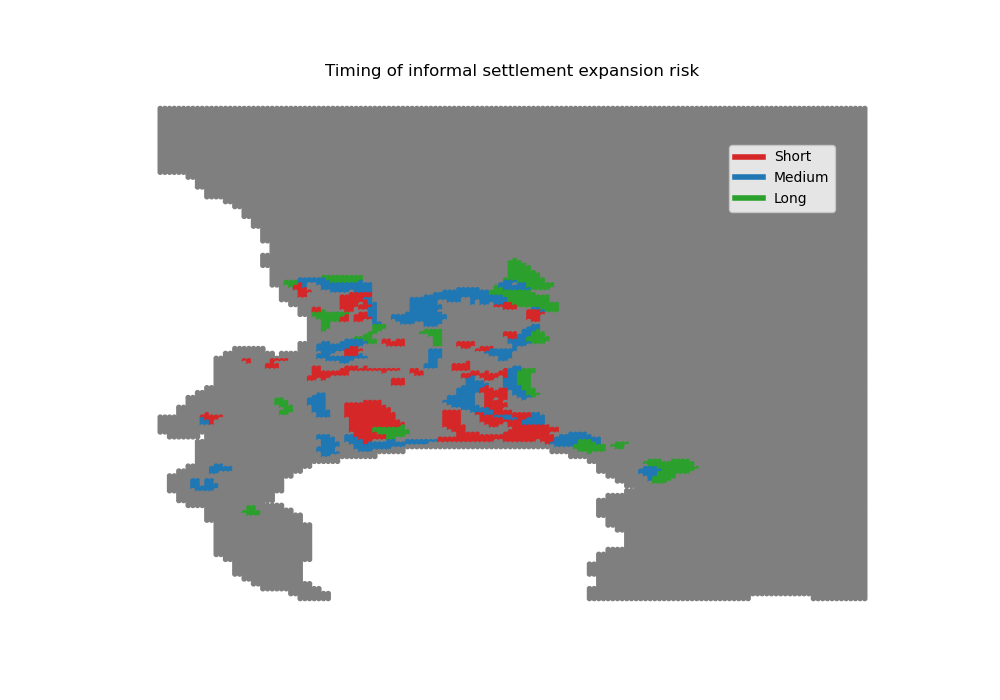

In [18]:
# First for timing
informal_risks_short = pd.read_csv(
    path_folder + 'occupation_maps/informal_settlements_risk_SHORT.csv',
    sep=',')
informal_risks_short = informal_risks_short.rename(
    columns={"area": "area_short"})
informal_risks_medium = pd.read_csv(
    path_folder + 'occupation_maps/informal_settlements_risk_MEDIUM.csv',
    sep=',')
informal_risks_medium = informal_risks_medium.rename(
    columns={"area": "area_medium"})
informal_risks_long = pd.read_csv(
    path_folder + 'occupation_maps/informal_settlements_risk_LONG.csv',
    sep=',')
informal_risks_long = informal_risks_long.rename(
    columns={"area": "area_long"})

informal_risks_timing = pd.concat(
    [informal_risks_short["area_short"],
     informal_risks_medium["area_medium"],
     informal_risks_long["area_long"]],
    axis=1)
informal_risks_timing["sum"] = (
    informal_risks_timing["area_short"]
    + informal_risks_timing["area_medium"]
    + informal_risks_timing["area_long"])
informal_risks_timing["argmax"] = np.zeros(24014)
informal_risks_timing["argmax"] = np.nan
informal_risks_timing[
    "argmax"][informal_risks_timing["sum"] > 0] = np.nanargmax(
        informal_risks_timing[["area_short", "area_medium", "area_long"]], 1)
informal_risks_timing["color"] = "tab:grey"
informal_risks_timing.loc[
    informal_risks_timing["argmax"] == 0, "color"] = "tab:red"
informal_risks_timing.loc[
    informal_risks_timing["argmax"] == 1, "color"] = "tab:blue"
informal_risks_timing.loc[
    informal_risks_timing["argmax"] == 2, "color"] = "tab:green"

plt.figure(figsize=(10, 7))
Map = plt.scatter(grid.x, grid.y, s=None,
                  c=informal_risks_timing["color"],
                  marker='.')
custom_lines = [Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="tab:blue", lw=4),
                Line2D([0], [0], color="tab:green", lw=4)]
plt.legend(custom_lines, ['Short', 'Medium', 'Long'],
           loc='upper right', bbox_to_anchor=(0.925, 0.9))
plt.axis('off')
plt.title("Timing of informal settlement expansion risk")
plt.savefig(path_input_plots + "informal_settlement_risk_timing")
plt.close()
informal_risks_timing.to_csv(path_input_tables
                             + 'informal_settlement_risk_timing.csv')

Image(path_input_plots + "informal_settlement_risk_timing.png")

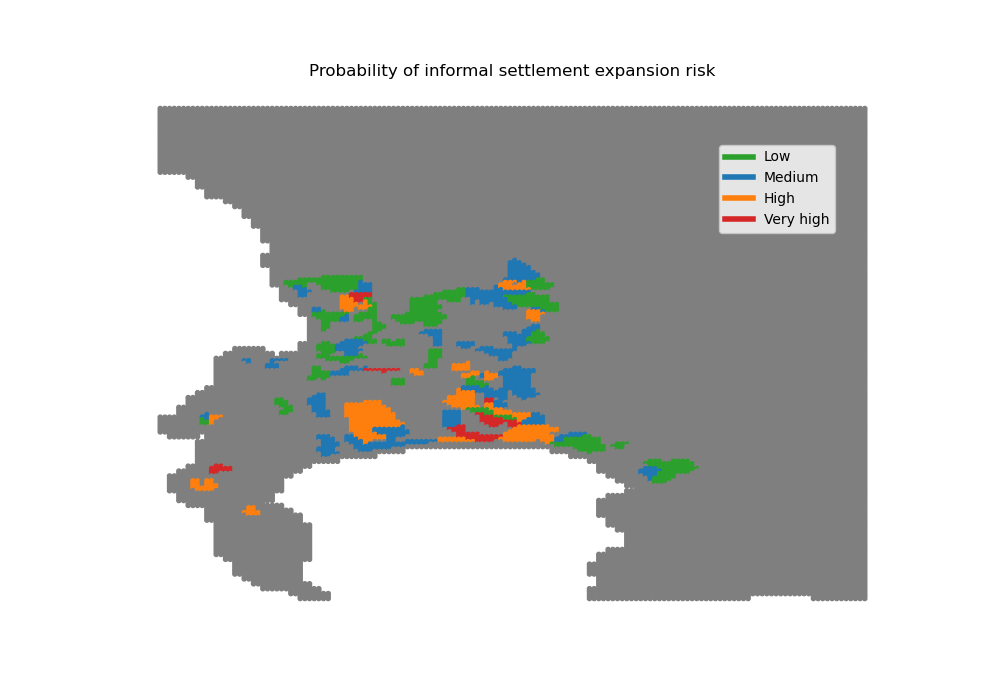

In [19]:
# Then for probability

informal_risks_LOW = pd.read_csv(
    path_folder + 'occupation_maps/informal_settlements_risk_pLOW.csv',
    sep=',')
informal_risks_LOW = informal_risks_LOW.rename(
    columns={"area": "area_LOW"})
informal_risks_MEDIUM = pd.read_csv(
    path_folder + 'occupation_maps/informal_settlements_risk_pMEDIUM.csv',
    sep=',')
informal_risks_MEDIUM = informal_risks_MEDIUM.rename(
    columns={"area": "area_MEDIUM"})
informal_risks_HIGH = pd.read_csv(
    path_folder + 'occupation_maps/informal_settlements_risk_pHIGH.csv',
    sep=',')
informal_risks_HIGH = informal_risks_HIGH.rename(
    columns={"area": "area_HIGH"})
informal_risks_VERYHIGH = pd.read_csv(
    path_folder + 'occupation_maps/informal_settlements_risk_pVERYHIGH.csv',
    sep=',')
informal_risks_VERYHIGH = informal_risks_VERYHIGH.rename(
    columns={"area": "area_VERYHIGH"})

informal_risks_proba = pd.concat(
    [informal_risks_LOW["area_LOW"],
     informal_risks_MEDIUM["area_MEDIUM"],
     informal_risks_HIGH["area_HIGH"],
     informal_risks_VERYHIGH["area_VERYHIGH"]],
    axis=1)
informal_risks_proba["sum"] = (
    informal_risks_proba["area_LOW"]
    + informal_risks_proba["area_MEDIUM"]
    + informal_risks_proba["area_HIGH"]
    + informal_risks_proba["area_VERYHIGH"])
informal_risks_proba["argmax"] = np.zeros(24014)
informal_risks_proba["argmax"] = np.nan
informal_risks_proba[
    "argmax"][informal_risks_proba["sum"] > 0] = np.nanargmax(
        informal_risks_proba[
            ["area_LOW", "area_MEDIUM", "area_HIGH", "area_VERYHIGH"]
            ], 1)
informal_risks_proba["color"] = "tab:grey"
informal_risks_proba.loc[
    informal_risks_proba["argmax"] == 0, "color"] = "tab:green"
informal_risks_proba.loc[
    informal_risks_proba["argmax"] == 1, "color"] = "tab:blue"
informal_risks_proba.loc[
    informal_risks_proba["argmax"] == 2, "color"] = "tab:orange"
informal_risks_proba.loc[
    informal_risks_proba["argmax"] == 3, "color"] = "tab:red"

plt.figure(figsize=(10, 7))
Map = plt.scatter(grid.x, grid.y, s=None,
                  c=informal_risks_proba["color"],
                  marker='.')
custom_lines = [Line2D([0], [0], color="tab:green", lw=4),
                Line2D([0], [0], color="tab:blue", lw=4),
                Line2D([0], [0], color="tab:orange", lw=4),
                Line2D([0], [0], color="tab:red", lw=4)]
plt.legend(custom_lines, ['Low', 'Medium', 'High', "Very high"],
           loc='upper right', bbox_to_anchor=(0.925, 0.9))
plt.axis('off')
plt.title("Probability of informal settlement expansion risk")
plt.savefig(path_input_plots + "informal_settlement_risk_proba")
plt.close()
informal_risks_proba.to_csv(path_input_tables
                            + 'informal_settlement_risk_proba.csv')

Image(path_input_plots + "informal_settlement_risk_proba.png")

In [20]:
# We correct areas for each housing type at baseline year for the amount of
# constructible land in each type
import inputs.data as inpdt
coeff_land = inpdt.import_coeff_land(
    spline_land_constraints, spline_land_backyard, spline_land_informal,
    spline_land_RDP, param, 0)

#### Let us visualize land availaibility at baseline year (2011)

coeff_land_formal done


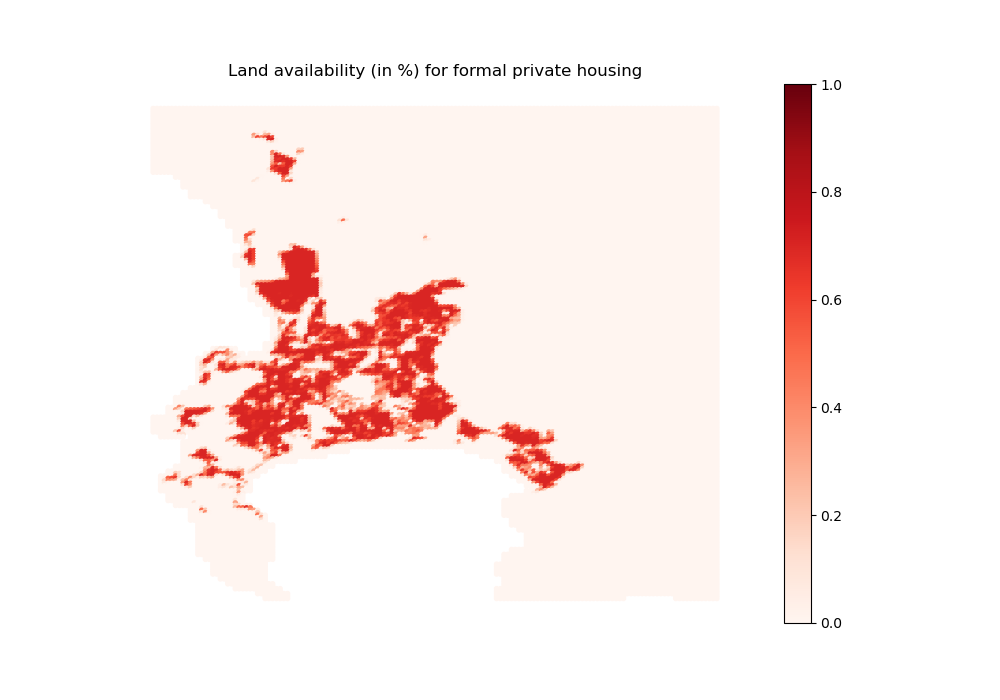

In [21]:
# For formal private housing
import outputs.export_outputs as outexp
coeff_land_FP_map = outexp.export_map(
    coeff_land[0], grid, geo_grid, path_input_plots, 'coeff_land_formal',
    "Land availability (in %) for formal private housing",
    path_input_tables,
    ubnd=1, lbnd=0)

Image(path_input_plots + "coeff_land_formal.png")

coeff_land_backyard done


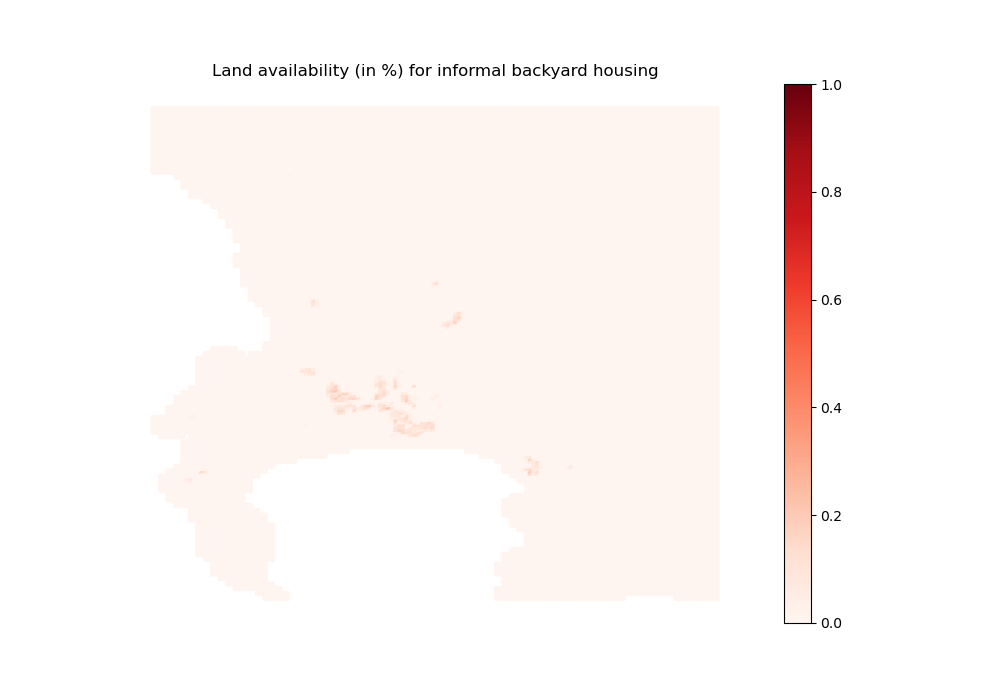

In [22]:
# For informal backyards
import outputs.export_outputs as outexp
coeff_land_IB_map = outexp.export_map(
    coeff_land[1], grid, geo_grid, path_input_plots, 'coeff_land_backyard',
    "Land availability (in %) for informal backyard housing",
    path_input_tables,
    ubnd=1, lbnd=0)

Image(path_input_plots + "coeff_land_backyard.png")

coeff_land_informal done


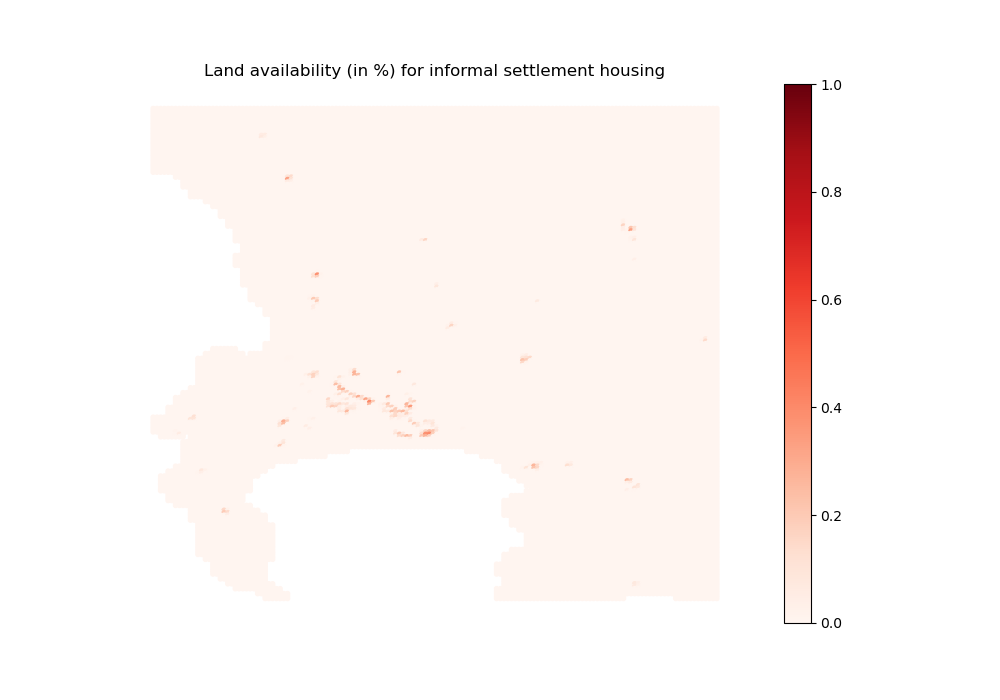

In [23]:
# For informal settlements
import outputs.export_outputs as outexp
coeff_land_IS_map = outexp.export_map(
    coeff_land[2], grid, geo_grid, path_input_plots, 'coeff_land_informal',
    "Land availability (in %) for informal settlement housing",
    path_input_tables,
    ubnd=1, lbnd=0)

Image(path_input_plots + "coeff_land_informal.png")

coeff_land_subsidized done


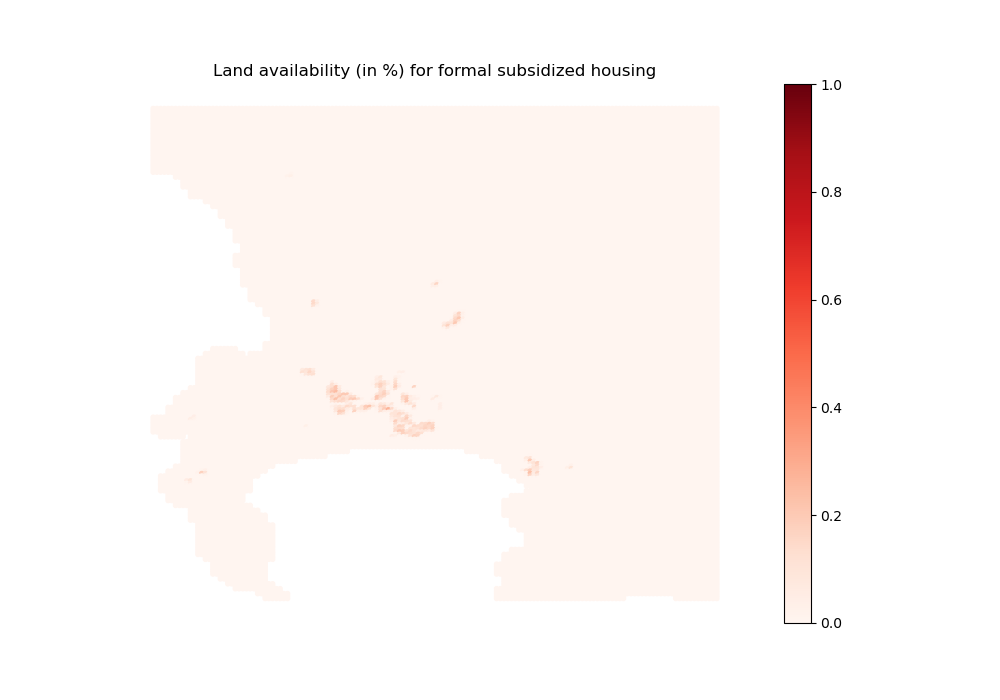

In [24]:
# For formal subsidized housing
import outputs.export_outputs as outexp
coeff_land_FS_map = outexp.export_map(
    coeff_land[3], grid, geo_grid, path_input_plots, 'coeff_land_subsidized',
    "Land availability (in %) for formal subsidized housing",
    path_input_tables,
    ubnd=1, lbnd=0)

Image(path_input_plots + "coeff_land_subsidized.png")

In [25]:
# We also import housing height limits
import inputs.data as inpdt
housing_limit = inpdt.import_housing_limit(grid, param)

In [26]:
# We update parameter vector with construction parameters
# (relies on loaded data) and compute other variables
import inputs.parameters_and_options as inpprm
(param, minimum_housing_supply, agricultural_rent
 ) = inpprm.import_construction_parameters(
    param, grid, housing_types_sp, data_sp["dwelling_size"],
    mitchells_plain_grid_baseline, grid_formal_density_HFA, coeff_land,
    interest_rate, options
    )

### Import flood data (takes some time when agents anticipate floods)

In [27]:
import inputs.data as inpdt
# If agents anticipate floods, we return output from damage functions
if options["agents_anticipate_floods"] == 1:
    (fraction_capital_destroyed, structural_damages_small_houses,
     structural_damages_medium_houses, structural_damages_large_houses,
     content_damages, structural_damages_type1, structural_damages_type2,
     structural_damages_type3a, structural_damages_type3b,
     structural_damages_type4a, structural_damages_type4b
     ) = inpdt.import_full_floods_data(options, param, path_folder)

# Else, we set those outputs as zero
# NB: 24014 is the number of grid pixels
elif options["agents_anticipate_floods"] == 0:
    fraction_capital_destroyed = pd.DataFrame()
    fraction_capital_destroyed["structure_formal_2"] = np.zeros(24014)
    fraction_capital_destroyed["structure_formal_1"] = np.zeros(24014)
    fraction_capital_destroyed["structure_subsidized_2"] = np.zeros(24014)
    fraction_capital_destroyed["structure_subsidized_1"] = np.zeros(24014)
    fraction_capital_destroyed["contents_formal"] = np.zeros(24014)
    fraction_capital_destroyed["contents_informal"] = np.zeros(24014)
    fraction_capital_destroyed["contents_subsidized"] = np.zeros(24014)
    fraction_capital_destroyed["contents_backyard"] = np.zeros(24014)
    fraction_capital_destroyed["structure_backyards"] = np.zeros(24014)
    fraction_capital_destroyed["structure_formal_backyards"] = np.zeros(24014)
    fraction_capital_destroyed["structure_informal_backyards"
                               ] = np.zeros(24014)
    fraction_capital_destroyed["structure_informal_settlements"
                               ] = np.zeros(24014)

FU_5yr
FU_10yr
FU_20yr
FU_50yr
FU_75yr
FU_100yr
FU_200yr
FU_250yr
FU_500yr
FU_1000yr
P_5yr
P_10yr
P_20yr
P_50yr
P_75yr
P_100yr
P_200yr
P_250yr
P_500yr
P_1000yr
C_MERITDEM_0_0000
C_MERITDEM_0_0002
C_MERITDEM_0_0005
C_MERITDEM_0_0010
C_MERITDEM_0_0025
C_MERITDEM_0_0050
C_MERITDEM_0_0100
C_MERITDEM_0_0250
Contents in private formal
Contents in informal settlements
Contents in (any) backyard
Contents in formal subsidized
Private formal structures (one floor)
Private formal structures (two floors)
Formal subsidized structures (one floor)
Formal subsidized structures (two floors)
Informal settlement structures
Informal backyard structures
Formal backyard structures (one floor)
Formal backyard structures (two floors)


#### Let us visualize flood data

We will first show some flood maps for visual reference, then the associated
fractions of capital destroyed computed through damage functions
(final damages depend on spatial sorting).

NB: all maps are undefended (do not take protective infrastructure into
account), and a return period of 100 years corresponds to a 1% chance of
occurrence in a given year.

FU_100yr_map_depth done


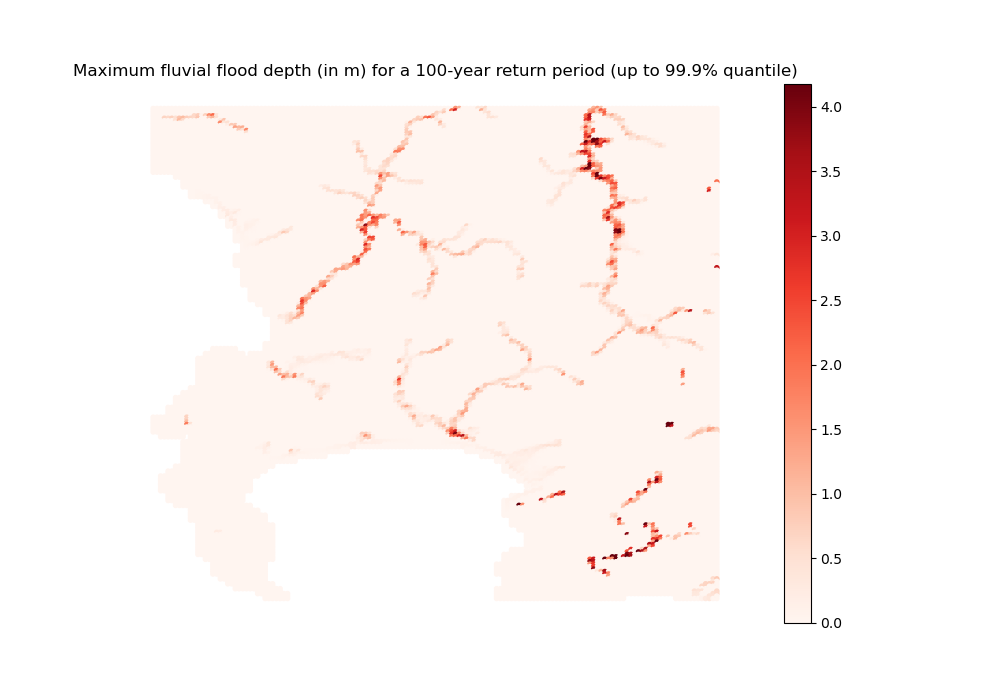

In [28]:
# Fluvial undefended maximum flood depth (in m) for a 100-year return period
ref_flood = np.squeeze(pd.read_excel(path_floods + "FU_100yr" + ".xlsx"))
ref_flood_depth = ref_flood["flood_depth"]
import outputs.export_outputs as outexp
ref_flood_map_depth = outexp.export_map(
    ref_flood_depth, grid, geo_grid,
    path_input_plots, 'FU_100yr' + '_map_depth',
    "Maximum fluvial flood depth (in m) for a 100-year return period (up to 99.9% quantile)",
    path_input_tables,
    ubnd=np.quantile(ref_flood_depth[~np.isnan(ref_flood_depth)], 0.999))

Image(path_input_plots + 'FU_100yr' + '_map_depth.png')

P_100yr_map_depth done


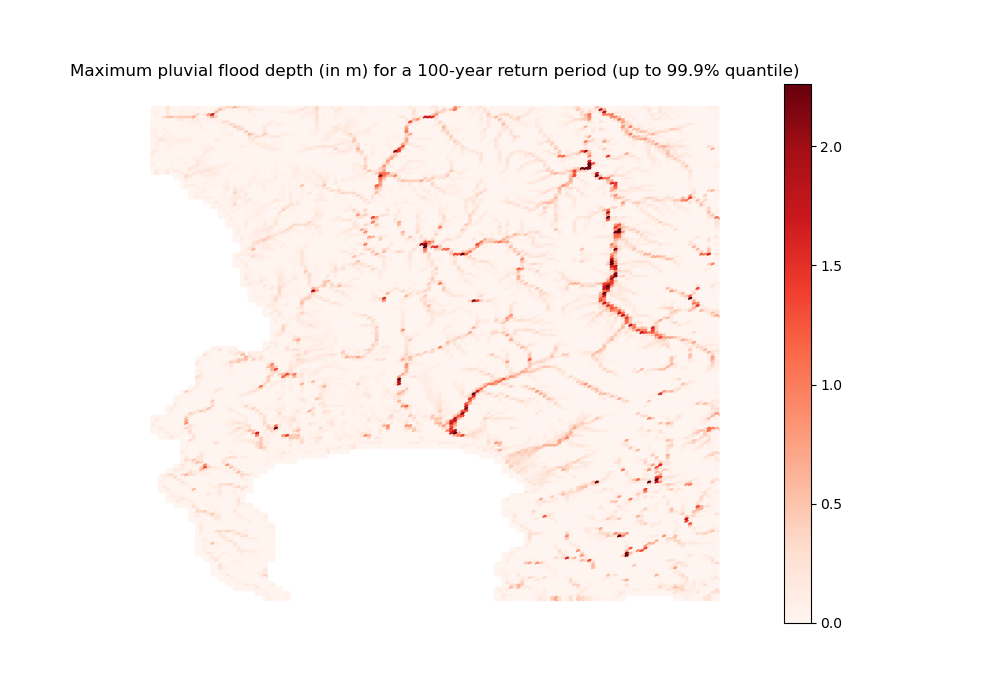

In [29]:
# Pluvial maximum flood depth (in m) for a 100-year return period
ref_flood = np.squeeze(pd.read_excel(path_floods + "P_100yr" + ".xlsx"))
ref_flood_depth = ref_flood["flood_depth"]
import outputs.export_outputs as outexp
ref_flood_map_depth = outexp.export_map(
    ref_flood_depth, grid, geo_grid,
    path_input_plots, 'P_100yr' + '_map_depth',
    "Maximum pluvial flood depth (in m) for a 100-year return period (up to 99.9% quantile)",
    path_input_tables,
    ubnd=np.quantile(ref_flood_depth[~np.isnan(ref_flood_depth)], 0.999))

Image(path_input_plots + 'P_100yr' + '_map_depth.png')

C_MERITDEM_1_0100_map_depth done


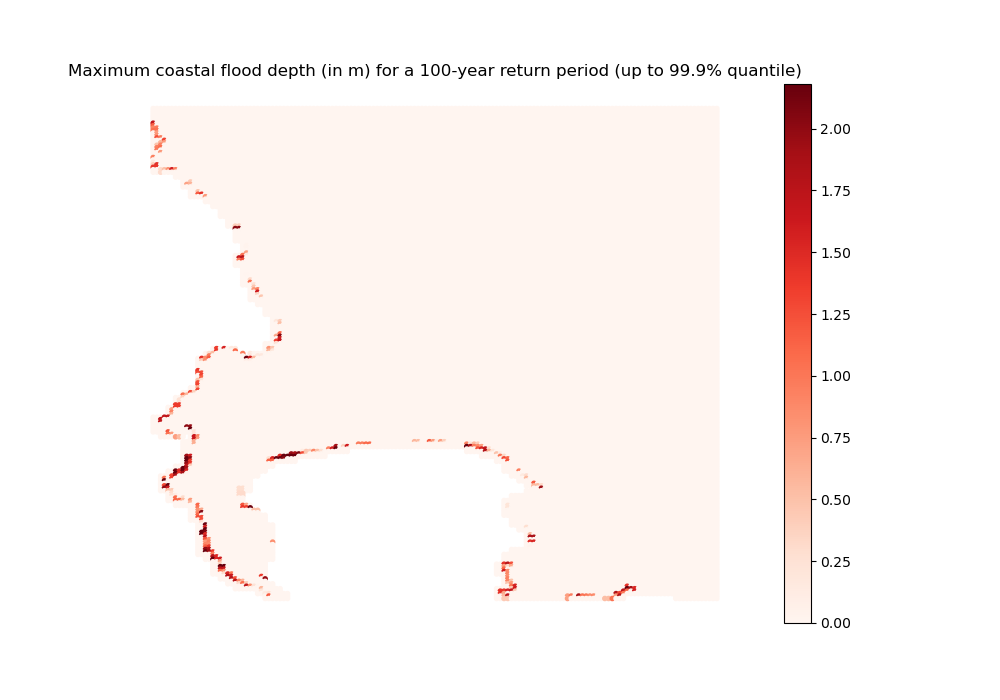

In [30]:
# Coastal maximum flood depth (in m) for a 100-year return period (without climate change)
ref_flood = np.squeeze(pd.read_excel(
    path_floods + "C_MERITDEM_0_0100" + ".xlsx"))
ref_flood_depth = ref_flood["flood_depth"]
import outputs.export_outputs as outexp
ref_flood_map_depth = outexp.export_map(
    ref_flood_depth, grid, geo_grid,
    path_input_plots, 'C_MERITDEM_1_0100' + '_map_depth',
    "Maximum coastal flood depth (in m) for a 100-year return period (up to 99.9% quantile)",
    path_input_tables,
    ubnd=np.quantile(ref_flood_depth[~np.isnan(ref_flood_depth)], 0.999))

Image(path_input_plots + 'C_MERITDEM_1_0100' + '_map_depth.png')

In [31]:
# We create the maps for fraction of capital destroyed before plotting them
import outputs.export_outputs as outexp
for col in fraction_capital_destroyed.columns:
    value = fraction_capital_destroyed[col]
    outexp.export_map(value, grid, geo_grid,
                      path_input_plots, col + '_fract_K_destroyed', "Calibrated fraction of capital destroyed",
                      path_input_tables,
                      ubnd=1)

contents_formal_fract_K_destroyed done
contents_informal_fract_K_destroyed done
contents_backyard_fract_K_destroyed done
contents_subsidized_fract_K_destroyed done
structure_formal_1_fract_K_destroyed done
structure_formal_2_fract_K_destroyed done
structure_subsidized_1_fract_K_destroyed done
structure_subsidized_2_fract_K_destroyed done
structure_informal_settlements_fract_K_destroyed done
structure_informal_backyards_fract_K_destroyed done
structure_formal_backyards_fract_K_destroyed done
structure_backyards_fract_K_destroyed done


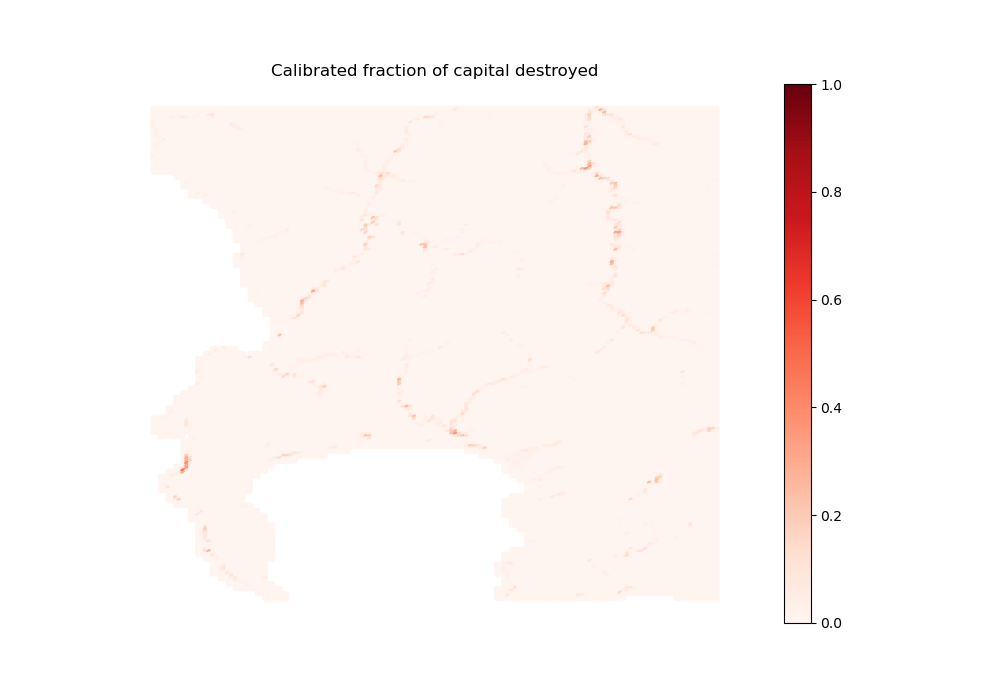

In [32]:
# For formal private housing structures
Image(path_input_plots + 'structure_formal_1' + '_fract_K_destroyed.png')

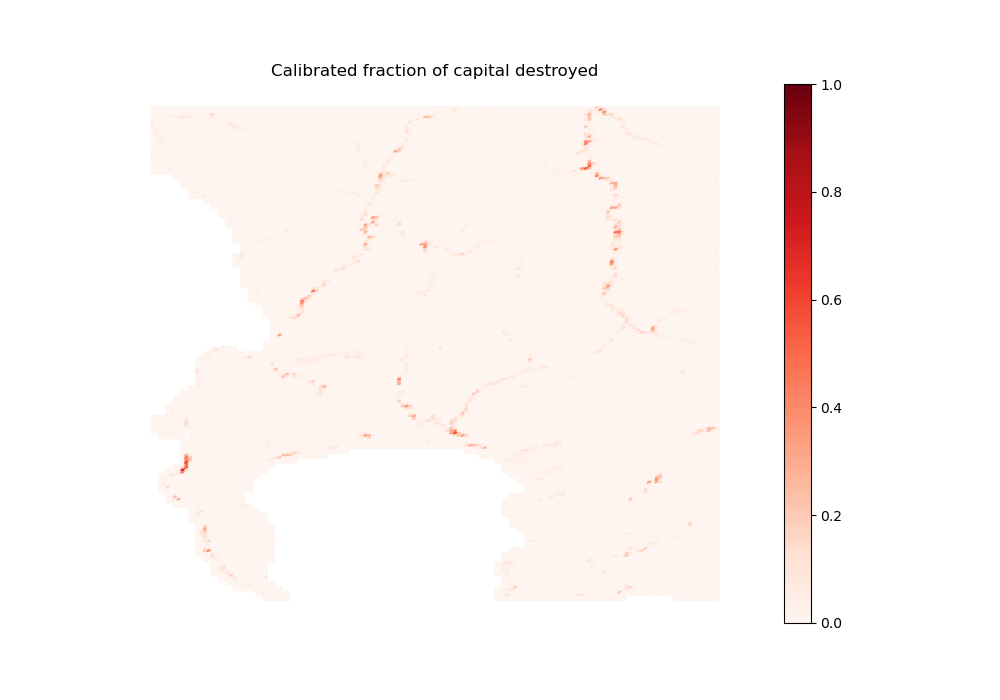

In [33]:
# For informal backyard structures
Image(path_input_plots + 'structure_informal_backyards'
      + '_fract_K_destroyed.png')

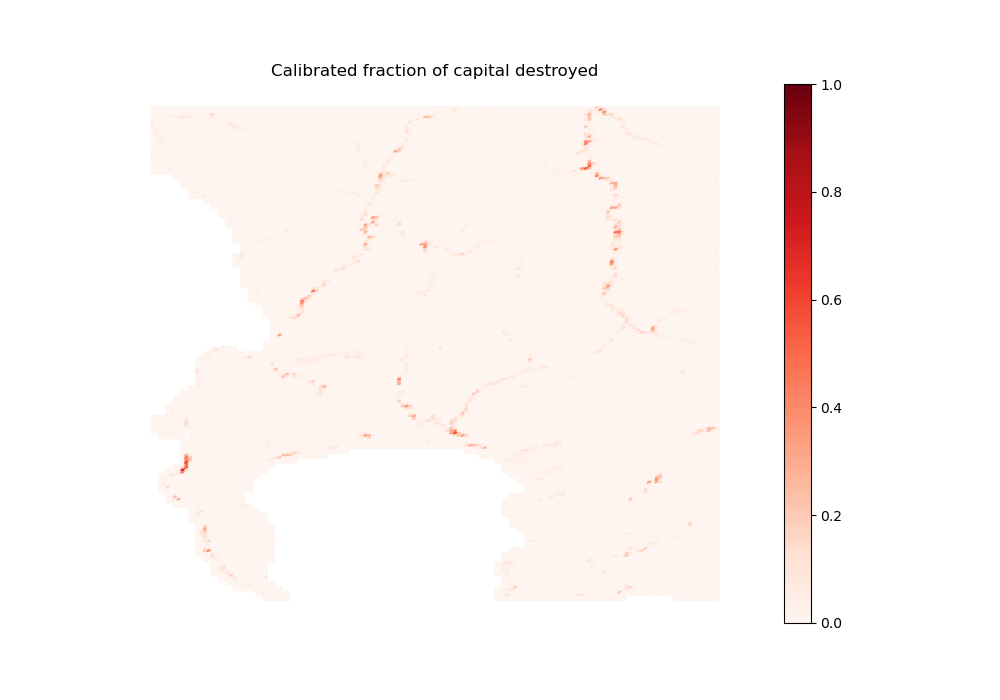

In [34]:
# For informal settlement structures
Image(path_input_plots + 'structure_informal_settlements' + '_fract_K_destroyed.png')

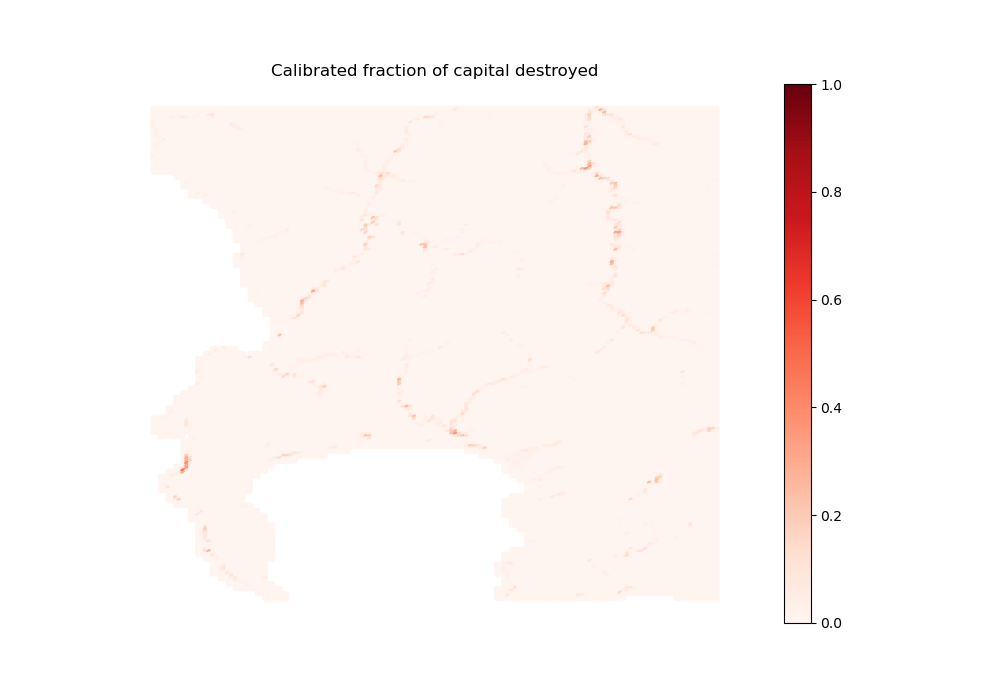

In [35]:
# For formal subsidized structures
Image(path_input_plots + 'structure_subsidized_1' + '_fract_K_destroyed.png')

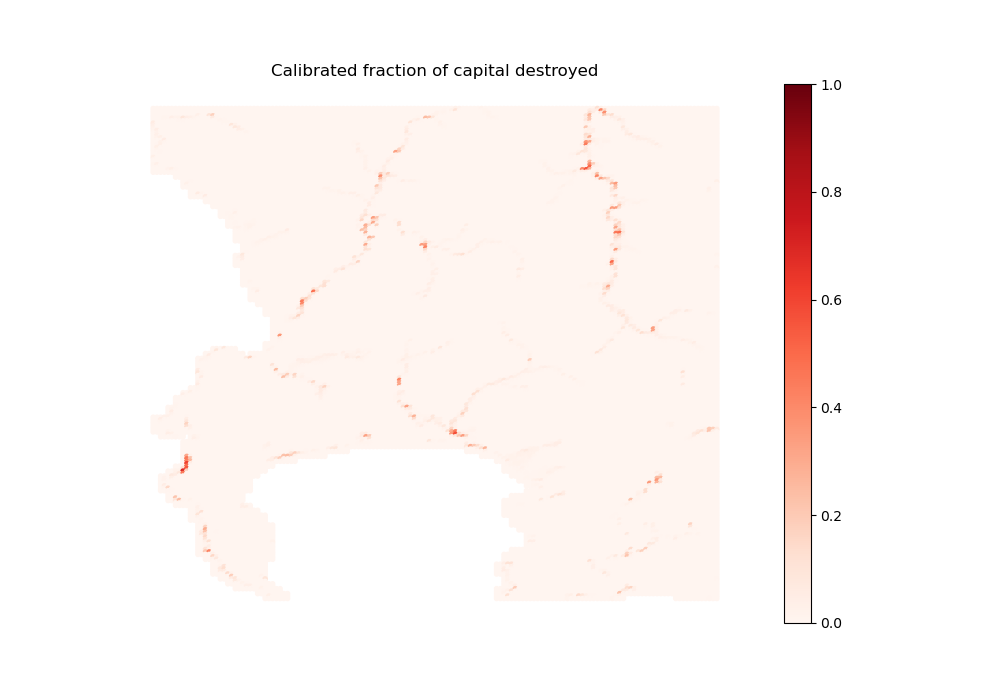

In [36]:
# For contents across all housing types (does not change)
Image(path_input_plots + 'contents_formal' + '_fract_K_destroyed.png')

### Import scenarios (for time-moving variables)

In [37]:
import equilibrium.functions_dynamic as eqdyn
(spline_agricultural_price, spline_interest_rate,
 spline_population_income_distribution, spline_inflation,
 spline_income_distribution, spline_population,
 spline_income, spline_minimum_housing_supply, spline_fuel
 ) = eqdyn.import_scenarios(income_baseline, param, grid, path_scenarios,
                            options)

### Import expected income net of commuting costs (for all time periods)

In [38]:
import inputs.data as inpdt
if options["compute_net_income"] == 1:
    for t_temp in t:
        print(t_temp)
        (incomeNetOfCommuting, modalShares, ODflows, averageIncome
         ) = inpdt.import_transport_data(
             grid, param, t_temp, households_per_income_class, average_income,
             spline_inflation, spline_fuel,
             spline_population_income_distribution, spline_income_distribution,
             path_precalc_inp, path_precalc_transp, 'GRID', options)

# Load the variable at baseline year
income_net_of_commuting_costs = np.load(
    path_precalc_transp + 'GRID_incomeNetOfCommuting_0.npy')

Note that this variable is computed through our commuting choice model,
based on calibrated incomes per income group and job center.

## Compute initial state equilibrium

In [39]:
# We run the algorithm
import equilibrium.compute_equilibrium as eqcmp
(initial_state_utility,
 initial_state_error,
 initial_state_simulated_jobs,
 initial_state_households_housing_types,
 initial_state_household_centers,
 initial_state_households,
 initial_state_dwelling_size,
 initial_state_housing_supply,
 initial_state_rent,
 initial_state_rent_matrix,
 initial_state_capital_land,
 initial_state_average_income,
 initial_state_limit_city) = eqcmp.compute_equilibrium(
     fraction_capital_destroyed,
     amenities,
     param,
     housing_limit,
     population,
     households_per_income_class,
     total_RDP,
     coeff_land,
     income_net_of_commuting_costs,
     grid,
     options,
     agricultural_rent,
     interest_rate,
     number_properties_RDP,
     average_income,
     mean_income,
     income_class_by_housing_type,
     minimum_housing_supply,
     param["coeff_A"],
     income_baseline)

stops when error_max_abs <0.001:  73%|████████████████      | 732/1000 [00:18<00:06, 40.61it/s, error_max_abs=0.000997]


Reminder: income groups are ranked from poorer to richer, and housing types
follow the following order: formal-backyard-informal-RDP

Note on outputs (with dimensions in same order as axes):

initial_state_utility = utility for each income group (no RDP)
  after optimization

initial_state_error = value of error term for each group after optimization

initial_state_simulated_jobs = total number of households per housing type
  (no RDP) and income group

initial_state_households_housing_types = number of households
  per housing type (with RDP) per pixel

initial_state_household_centers = number of households per income group
  per pixel

initial_state_households = number of households in each housing type
  and income group per pixel

initial_state_dwelling_size = dwelling size (in m²) for each housing type
  per pixel

initial_state_housing_supply = housing surface built (in m²) per unit of
  available land (in km²) for each housing type in each pixel

initial_state_rent = average rent (in rands/m²) for each housing type
  in each pixel

initial_state_rent_matrix = average willingness to pay (in rands)
  for each housing type (no RDP) and each income group in each pixel

initial_state_capital_land = value of the (housing construction sector)
  capital stock (in monetary units) per unit of available
  land (in km²) in each housing type (no RDP) and each selected pixel

initial_state_average_income = average income per income group
  (not an output of the model)

initial_state_limit_city = indicator dummy for having strictly more
  than one household per housing type and income group in each pixel

In [40]:
print(initial_state_simulated_jobs)

[[     0.              0.         593544.08351385 325441.12387124]
 [155068.89113941 277975.90342027      0.              0.        ]
 [444864.52973064  66909.08899275      0.              0.        ]]


In [41]:
np.nansum(initial_state_simulated_jobs,1)

array([918985.20738509, 433044.79455967, 511773.61872339])

We observe that the poorest income group is crowded out of the formal private sector, and is the only one living in informal settlements and informal backyards.

In [42]:
# We create the associated output directory
try:
    os.mkdir(path_outputs + name)
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: '../Output/floods10_F0_P11_C10_scenario232_pop_increase'


In [43]:
# We save the output
np.save(path_outputs + name + '/initial_state_utility.npy',
        initial_state_utility)
np.save(path_outputs + name + '/initial_state_error.npy',
        initial_state_error)
np.save(path_outputs + name + '/initial_state_simulated_jobs.npy',
        initial_state_simulated_jobs)
np.save(path_outputs + name + '/initial_state_households_housing_types.npy',
        initial_state_households_housing_types)
np.save(path_outputs + name + '/initial_state_household_centers.npy',
        initial_state_household_centers)
np.save(path_outputs + name + '/initial_state_households.npy',
        initial_state_households)
np.save(path_outputs + name + '/initial_state_dwelling_size.npy',
        initial_state_dwelling_size)
np.save(path_outputs + name + '/initial_state_housing_supply.npy',
        initial_state_housing_supply)
np.save(path_outputs + name + '/initial_state_rent.npy',
        initial_state_rent)
np.save(path_outputs + name + '/initial_state_rent_matrix.npy',
        initial_state_rent_matrix)
np.save(path_outputs + name + '/initial_state_capital_land.npy',
        initial_state_capital_land)
np.save(path_outputs + name + '/initial_state_average_income.npy',
        initial_state_average_income)
np.save(path_outputs + name + '/initial_state_limit_city.npy',
        initial_state_limit_city)

### Let us visualize key equilibrium outputs

#### Let us start with population distribution

We first look at sorting across housing types.

formal_sim done


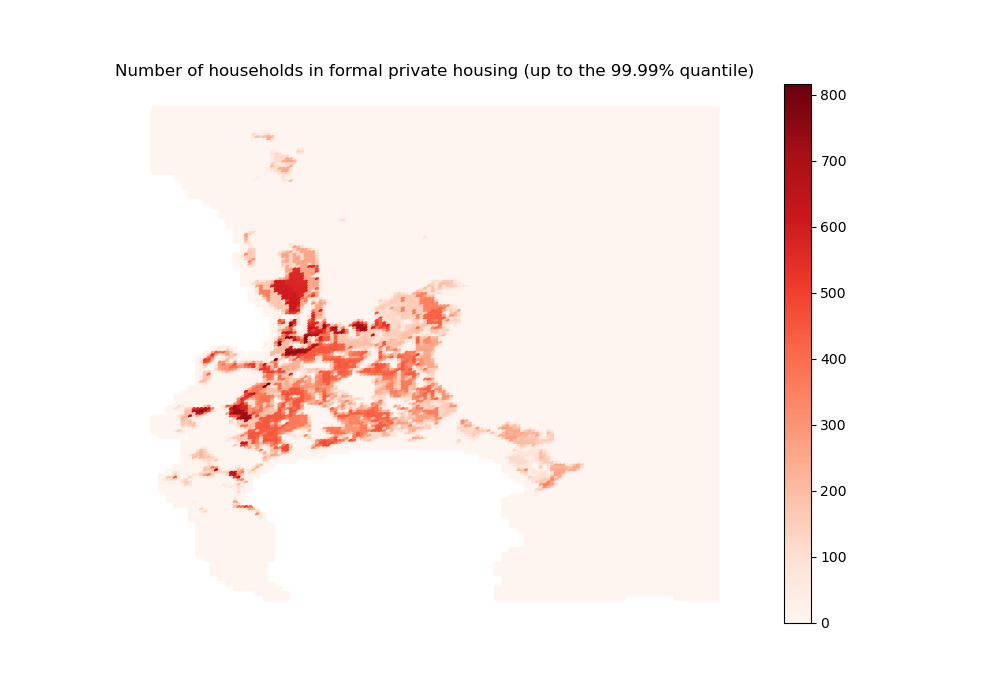

In [44]:
# For formal private housing
sim_nb_households_formal = initial_state_households_housing_types[0, :]
import outputs.export_outputs as outexp
formal_sim = outexp.export_map(
    sim_nb_households_formal, grid, geo_grid, path_output_plots, 'formal_sim',
    "Number of households in formal private housing (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(sim_nb_households_formal[~np.isnan(sim_nb_households_formal)], 0.9999))

Image(path_output_plots + 'formal_sim.png')

Here are a few caveats on how to interpret those results:

- For a given housing type, residential locations only vary a priori according to their (dis)amenity index, income net of commuting costs, and exposure to flood risks. We do not account for other location-specific exogenous factors. Besides, land availability is defined negatively by the share of land not available for other housing types, but in reality, this land may also be allocated to other uses, such as commercial real estate. Therefore, even though we do simulate the model at the grid-cell level, it makes more sense to interpret results at the scale of the neighbourhood.
<br>

- The fact that we are not able to replicate some stylized facts for the CoCT should be interpreted in this regard.

backyard_sim done


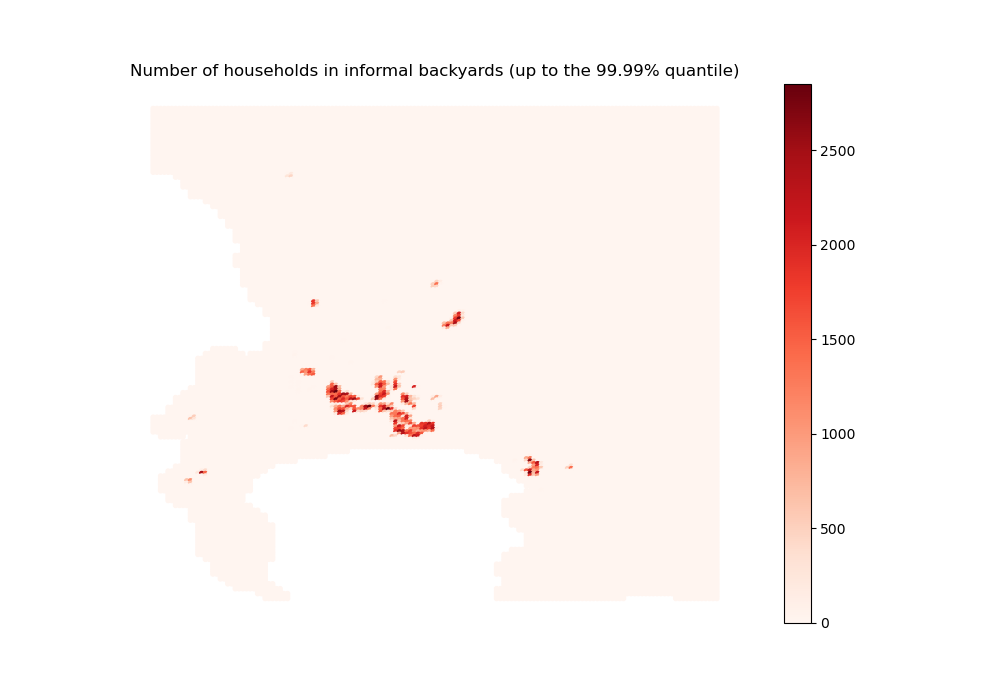

In [45]:
# For informal backyards
sim_nb_households_backyard = initial_state_households_housing_types[1, :]
import outputs.export_outputs as outexp
backyard_sim = outexp.export_map(
    sim_nb_households_backyard, grid, geo_grid, path_output_plots,
    'backyard_sim', "Number of households in informal backyards (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(sim_nb_households_backyard[~np.isnan(sim_nb_households_backyard)], 0.9999))

Image(path_output_plots + 'backyard_sim.png')

Remember that backyarding essentially occurs within (exogenous) formal subsidized housing premises, hence the observed spatial distribution.

informal_sim done


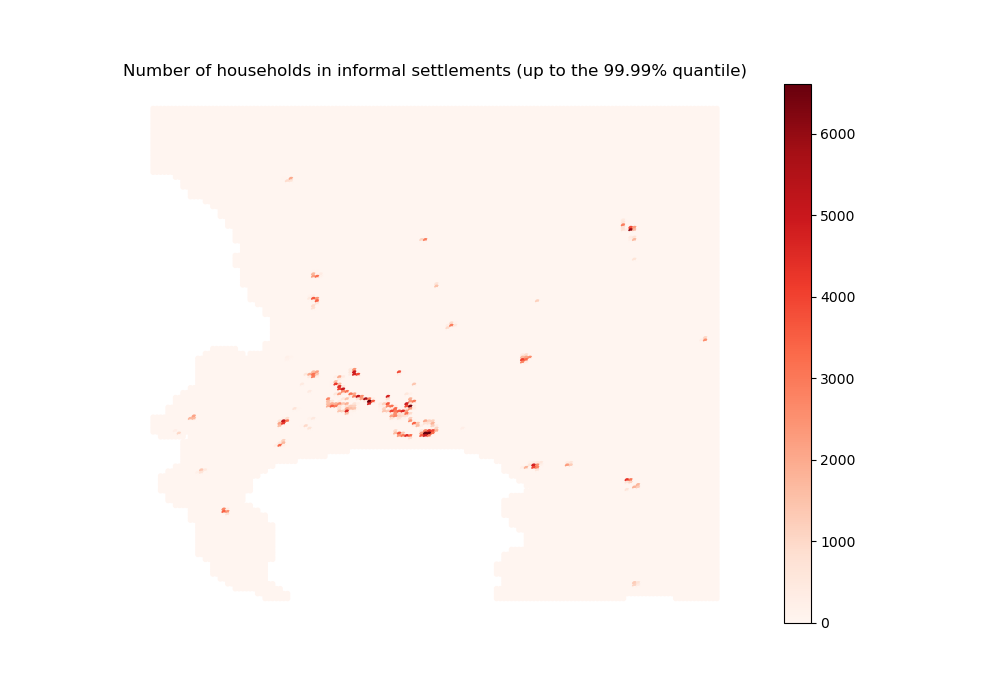

In [46]:
# For informal settlements
sim_nb_households_informal = initial_state_households_housing_types[2, :]
import outputs.export_outputs as outexp
informal_sim = outexp.export_map(
    sim_nb_households_informal, grid, geo_grid, path_output_plots,
    'informal_sim',
    "Number of households in informal settlements (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(sim_nb_households_informal[~np.isnan(sim_nb_households_informal)], 0.9999))

Image(path_output_plots + 'informal_sim.png')

Again, remember that informal settlement locations (not their population) are exogenously set.

rdp_sim done


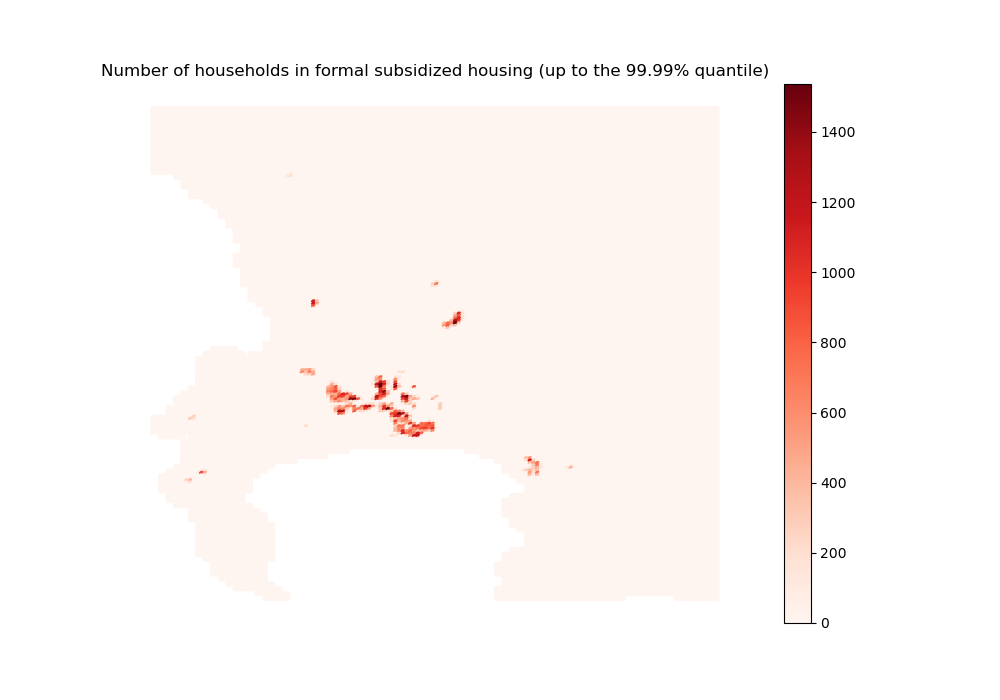

In [47]:
# For formal subsidized housing
data_nb_households_rdp = initial_state_households_housing_types[3, :]
import outputs.export_outputs as outexp
rdp_sim = outexp.export_map(
    data_nb_households_rdp, grid, geo_grid, path_output_plots, 'rdp_sim',
    "Number of households in formal subsidized housing (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(data_nb_households_rdp[~np.isnan(data_nb_households_rdp)], 0.9999))

Image(path_output_plots + 'rdp_sim.png')

Finally, the spatial distribution for formal subsidized housing is just taken from the data (not simulated).

We then look at sorting across income groups.

poor_sim done


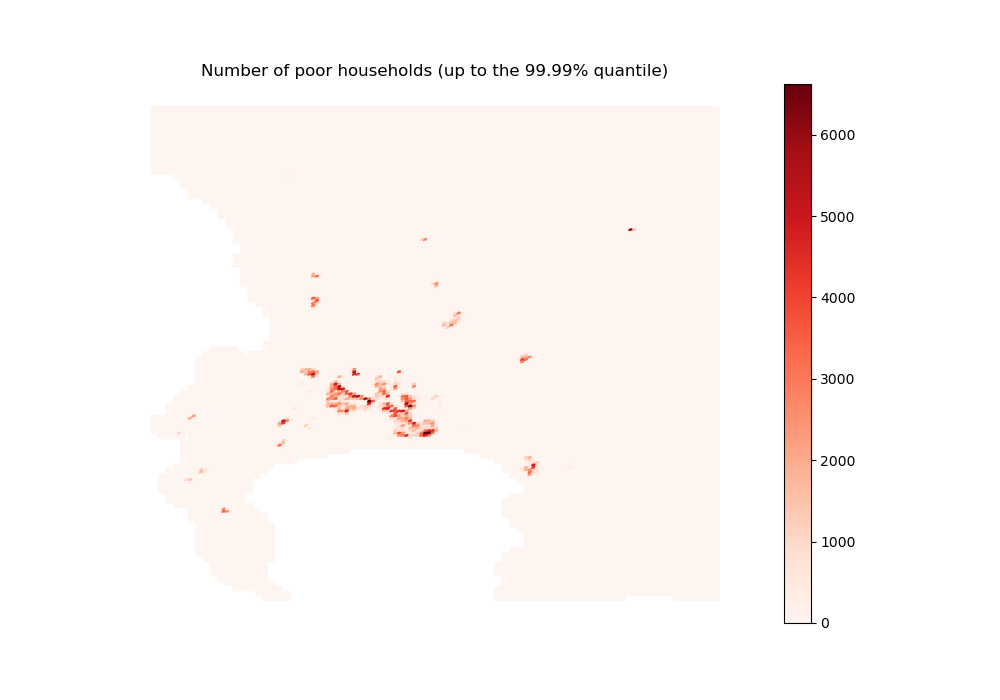

In [48]:
# For income group 1
sim_nb_households_poor = initial_state_household_centers[0, :]
import outputs.export_outputs as outexp
poor_sim = outexp.export_map(
    sim_nb_households_poor, grid, geo_grid, path_output_plots, 'poor_sim',
    "Number of poor households (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(sim_nb_households_poor[~np.isnan(sim_nb_households_poor)], 0.9999))

Image(path_output_plots + 'poor_sim.png')

midpoor_sim done


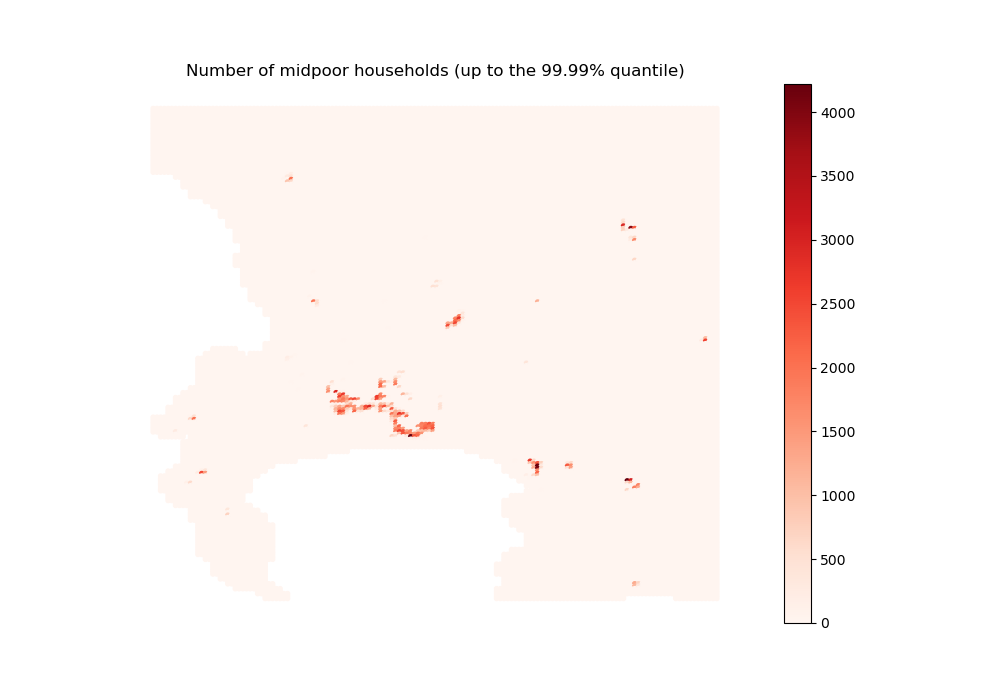

In [49]:
# For income group 2
sim_nb_households_midpoor = initial_state_household_centers[1, :]
import outputs.export_outputs as outexp
midpoor_sim = outexp.export_map(
    sim_nb_households_midpoor, grid, geo_grid, path_output_plots,
    'midpoor_sim', "Number of midpoor households (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(sim_nb_households_midpoor[~np.isnan(sim_nb_households_midpoor)], 0.9999))

Image(path_output_plots + 'midpoor_sim.png')

midrich_sim done


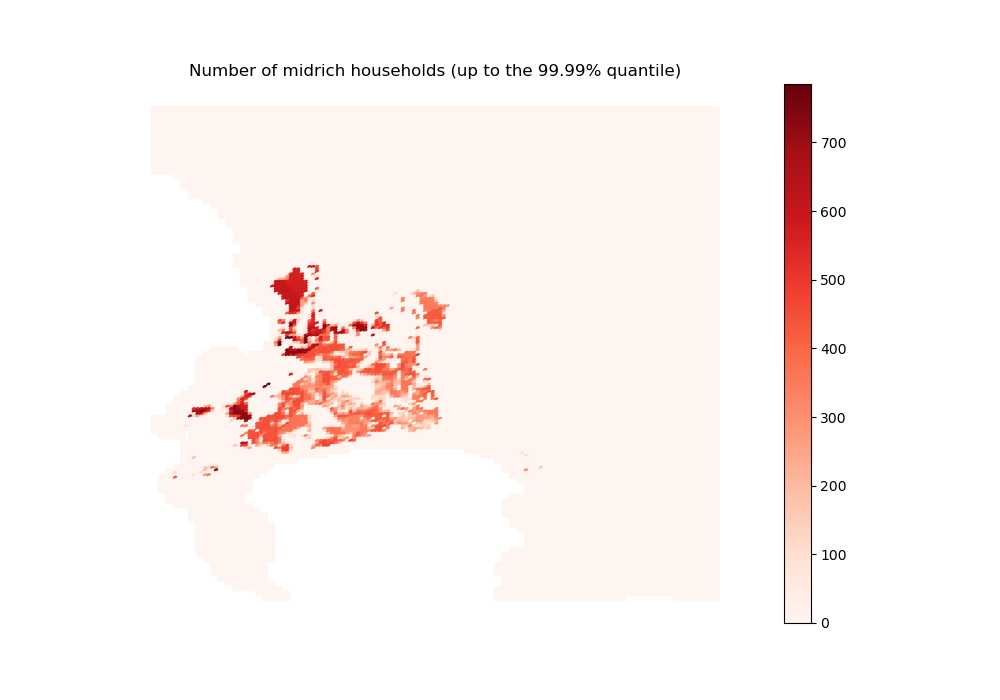

In [50]:
# For income group 3
sim_nb_households_midrich = initial_state_household_centers[2, :]
import outputs.export_outputs as outexp
midrich_sim = outexp.export_map(
    sim_nb_households_midrich, grid, geo_grid, path_output_plots,
    'midrich_sim', "Number of midrich households (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(sim_nb_households_midrich[~np.isnan(sim_nb_households_midrich)], 0.9999))

Image(path_output_plots + 'midrich_sim.png')

rich_sim done


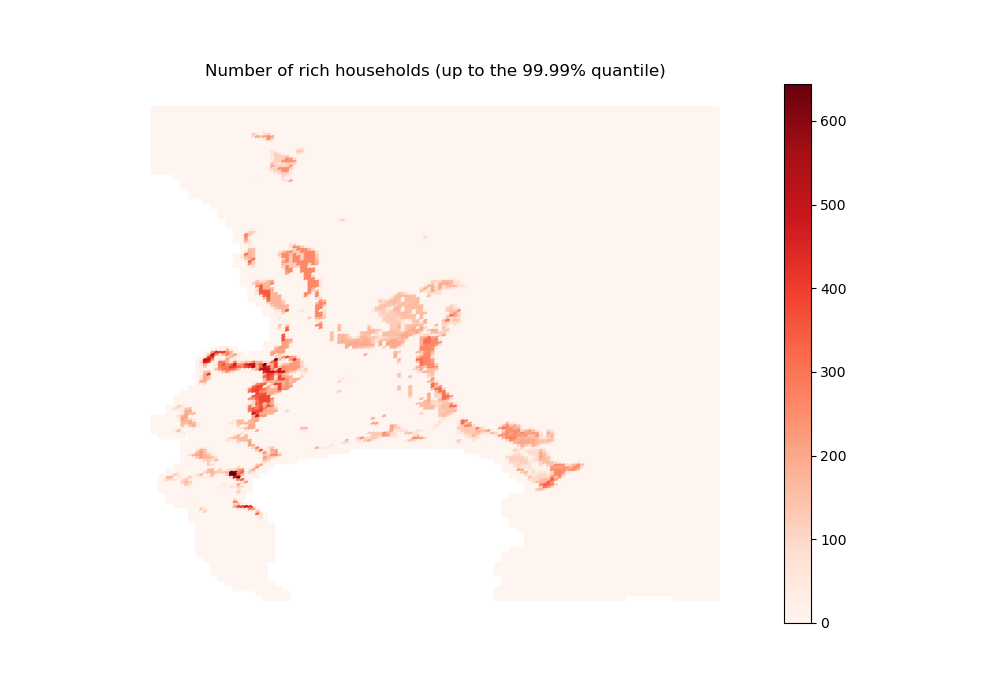

In [51]:
# For income group 4
sim_nb_households_rich = initial_state_household_centers[3, :]
import outputs.export_outputs as outexp
rich_sim = outexp.export_map(
    sim_nb_households_rich, grid, geo_grid, path_output_plots, 'rich_sim',
    "Number of rich households (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(sim_nb_households_rich[~np.isnan(sim_nb_households_rich)], 0.9999))

Image(path_output_plots + 'rich_sim.png')

Overall, the distribution of the two poorest income groups is in line with what we could expect given their opportunities on the housing market: being (parly or fully) crowded out of the formal private segment, they redirect themselves to the informal segments and the formal subsidized segment (for those eligible).

The second richest group, which makes up the most part of formal private housing dwellers, illustrates the standard urban economics trade-off between job accessibility and high rents / small dwelling sizes, with a peak at mid-distance (abstracting from location specifics).

The richest income group, who has a higher opportunity cost of time (and better job opportunities), crowds out the second richest group near the CBD, but also does locate in more peripheral high-amenity areas where they overbid the second richest group.

#### We may also look at housing supply (in m²)

In [52]:
# We multiply housing supply per unit of available land by the total area
# of a grid cell to recover absolute values of housing supply in each cell
housing_supply = initial_state_housing_supply * coeff_land * 0.25

hsupply_formal_2d_sim done


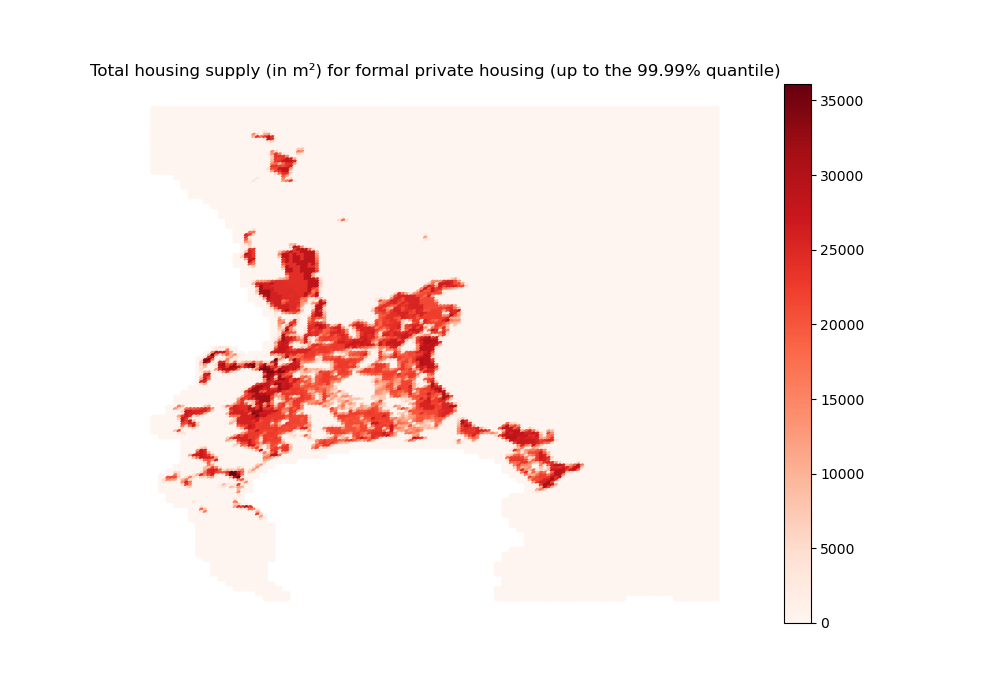

In [53]:
# For formal private housing
hsupply_formal = housing_supply[0, :]
import outputs.export_outputs as outexp
hsupply_formal_2d_sim = outexp.export_map(
    hsupply_formal, grid, geo_grid, path_output_plots, 'hsupply_formal_2d_sim',
    "Total housing supply (in m²) for formal private housing (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(hsupply_formal[~np.isnan(hsupply_formal)], 0.9999))

Image(path_output_plots + 'hsupply_formal_2d_sim.png')

hsupply_backyard_2d_sim done


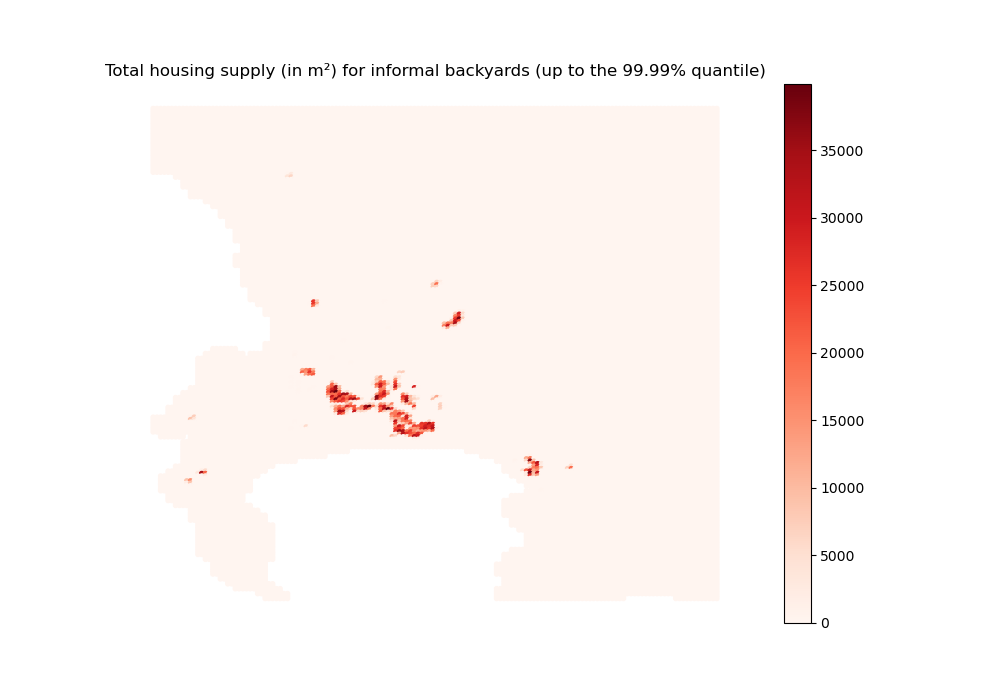

In [54]:
# For informal backyards
hsupply_backyard = housing_supply[1, :]
import outputs.export_outputs as outexp
hsupply_backyard_2d_sim = outexp.export_map(
    hsupply_backyard, grid, geo_grid, path_output_plots,
    'hsupply_backyard_2d_sim',
    "Total housing supply (in m²) for informal backyards (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(hsupply_backyard[~np.isnan(hsupply_backyard)], 0.9999))

Image(path_output_plots + 'hsupply_backyard_2d_sim.png')

hsupply_informal_2d_sim done


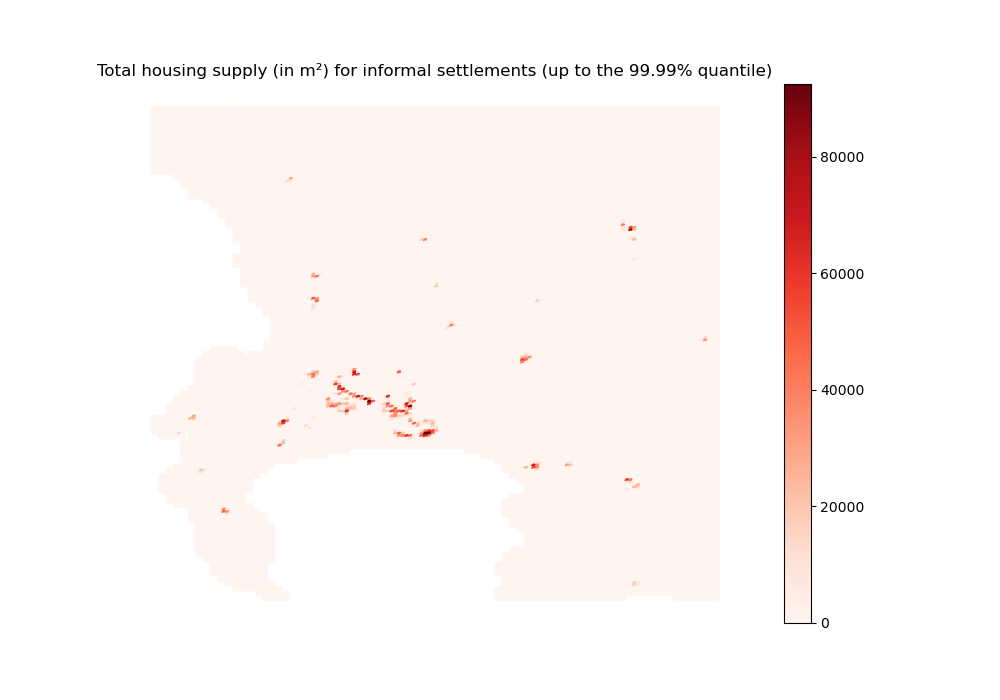

In [55]:
# For informal settlements
hsupply_informal = housing_supply[2, :]
import outputs.export_outputs as outexp
hsupply_informal_2d_sim = outexp.export_map(
    hsupply_informal, grid, geo_grid, path_output_plots,
    'hsupply_informal_2d_sim',
    "Total housing supply (in m²) for informal settlements (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(hsupply_informal[~np.isnan(hsupply_informal)], 0.9999))

Image(path_output_plots + 'hsupply_informal_2d_sim.png')

hsupply_rdp_2d_sim done


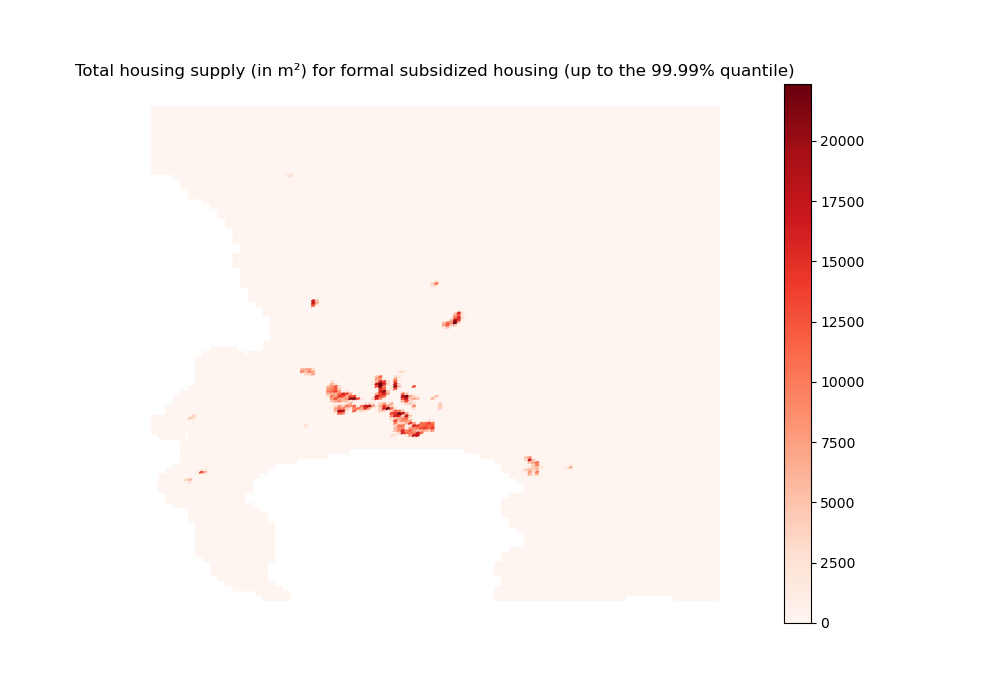

In [56]:
# For formal subsidized housing
hsupply_rdp = housing_supply[3, :]
import outputs.export_outputs as outexp
hsupply_rdp_2d_sim = outexp.export_map(
    hsupply_rdp, grid, geo_grid, path_output_plots, 'hsupply_rdp_2d_sim',
    "Total housing supply (in m²) for formal subsidized housing (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(hsupply_rdp[~np.isnan(hsupply_rdp)], 0.9999))

Image(path_output_plots + 'hsupply_rdp_2d_sim.png')

We do observe that informal settlements are somewhat denser than other housing types. This seems to indicate that horizontal densification dominates vertical densification within the context of the CoCT. Indeed, even though formal private housing can be built high, it is less constrained in terms of land availability and can spread out more, leaving some open space. On the contrary, as informal settlements are more constrained and can only expand horizontally, they end up using most of the available land.

NB: Note that the model does not allow us to disentangle between high structures with small dwelling units and low structures with big dwelling units within the formal private housing sector.

#### Now, let us look at land prices (in rands / m²)

In [57]:
# We first convert our estimates for the average annual rents into land prices
# based on the zero profit condition for developers
land_price = (
    (initial_state_rent[0:3, :] * param["coeff_A"])
    ** (1 / param["coeff_a"])
    * param["coeff_a"]
    * (param["coeff_b"] / (interest_rate + param["depreciation_rate"]))
    ** (param["coeff_b"] / param["coeff_a"])
    / interest_rate
    )

landprice_formal_2d_sim done


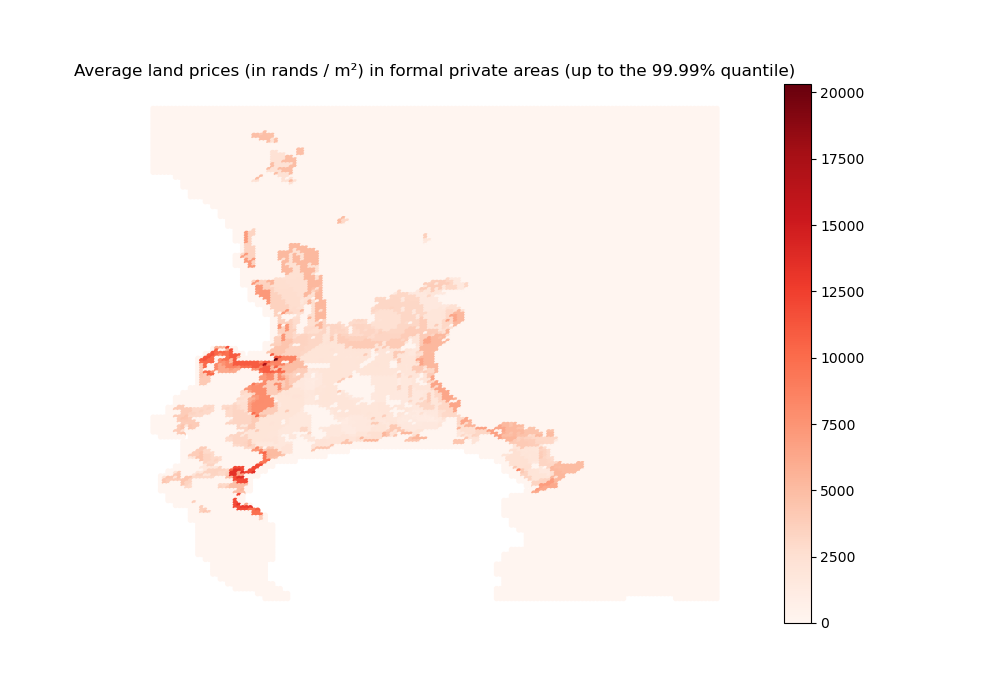

In [58]:
# For formal private housing
landprice_formal_simul = land_price[0, :].copy()
landprice_formal_simul[hsupply_formal==0 | np.isnan(hsupply_formal)] = 0

import outputs.export_outputs as outexp
land_price_formal_2d_sim = outexp.export_map(
    landprice_formal_simul, grid, geo_grid,
    path_output_plots, 'landprice_formal_2d_sim',
    "Average land prices (in rands / m²) in formal private areas (up to the 99.99% quantile)",
    path_output_tables,
    ubnd=np.quantile(landprice_formal_simul[landprice_formal_simul > 0], 0.9999))

Image(path_output_plots + 'landprice_formal_2d_sim.png')

Our results conform to the standard urban economics predictions about the overall shape of the housing/land rent/price gradient, modulated by the value of the amenity score.

Note that, although we also simulate the average annual rents for informal backyards and settlements, it is not absolutely rigorous to apply the above formula to recover land prices in those areas, as they are considered unfit for development. We cannot look at formal subsidized housing areas either, since such housing is rented out for free in the model.

#### Finally, let us look at flood damages (in rands)

In the interest of space and for illustrative purposes, we only show results
for the formal private sector structures (which are also the biggest in
absolute terms). We redirect the reader to the use cases for a more detailed view.

In [59]:
# We first list the flood map labels to be used
fluvialu_floods = ['FU_5yr', 'FU_10yr', 'FU_20yr', 'FU_50yr', 'FU_75yr',
                   'FU_100yr', 'FU_200yr', 'FU_250yr', 'FU_500yr', 'FU_1000yr']
pluvial_floods = ['P_5yr', 'P_10yr', 'P_20yr', 'P_50yr', 'P_75yr', 'P_100yr',
                  'P_200yr', 'P_250yr', 'P_500yr', 'P_1000yr']
coastal_floods = ['C_MERITDEM_' + str(options['climate_change']) + '_0000',
                  'C_MERITDEM_' + str(options['climate_change']) + '_0002',
                  'C_MERITDEM_' + str(options['climate_change']) + '_0005',
                  'C_MERITDEM_' + str(options['climate_change']) + '_0010',
                  'C_MERITDEM_' + str(options['climate_change']) + '_0025',
                  'C_MERITDEM_' + str(options['climate_change']) + '_0050',
                  'C_MERITDEM_' + str(options['climate_change']) + '_0100',
                  'C_MERITDEM_' + str(options['climate_change']) + '_0250']

In [60]:
# We compute the full values of exposed formal private structures and contents,
# for each housing type and a representative household
import outputs.flood_outputs as outfld

content_cost = outfld.compute_content_cost(
    initial_state_households, initial_state_housing_supply,
    income_net_of_commuting_costs, param,
    fraction_capital_destroyed, initial_state_rent,
    initial_state_dwelling_size, interest_rate)

formal_structure_cost = outfld.compute_formal_structure_cost(
        initial_state_capital_land, initial_state_households_housing_types,
        coeff_land)

In [61]:
# We re-import flood data to be able to compute damages a posteriori, when
# agents are set not to anticipate floods, hence do not take them into account,
# even if they actually do occur

import inputs.data as inpdt
(fraction_capital_destroyed, structural_damages_small_houses,
 structural_damages_medium_houses, structural_damages_large_houses,
 content_damages, structural_damages_type1, structural_damages_type2,
 structural_damages_type3a, structural_damages_type3b,
 structural_damages_type4a, structural_damages_type4b
 ) = inpdt.import_full_floods_data(options, param, path_folder)


FU_5yr
FU_10yr
FU_20yr
FU_50yr
FU_75yr
FU_100yr
FU_200yr
FU_250yr
FU_500yr
FU_1000yr
P_5yr
P_10yr
P_20yr
P_50yr
P_75yr
P_100yr
P_200yr
P_250yr
P_500yr
P_1000yr
C_MERITDEM_0_0000
C_MERITDEM_0_0002
C_MERITDEM_0_0005
C_MERITDEM_0_0010
C_MERITDEM_0_0025
C_MERITDEM_0_0050
C_MERITDEM_0_0100
C_MERITDEM_0_0250
Contents in private formal
Contents in informal settlements
Contents in (any) backyard
Contents in formal subsidized
Private formal structures (one floor)
Private formal structures (two floors)
Formal subsidized structures (one floor)
Formal subsidized structures (two floors)
Informal settlement structures
Informal backyard structures
Formal backyard structures (one floor)
Formal backyard structures (two floors)


In [62]:
# From there, we recover aggregate damages associated to each flood type
# per return period
import outputs.flood_outputs as outfld

fluvialu_damages_2d_sim = outfld.compute_damages_2d(
    fluvialu_floods, path_floods, param, content_cost,
    sim_nb_households_formal, data_nb_households_rdp,
    sim_nb_households_informal, sim_nb_households_backyard,
    initial_state_dwelling_size, formal_structure_cost, content_damages,
    structural_damages_type4b, structural_damages_type4a,
    structural_damages_type2, structural_damages_type3a, options,
    spline_inflation, 0, path_output_tables, 'fluvialu_sim')

pluvial_damages_2d_sim = outfld.compute_damages_2d(
    pluvial_floods, path_floods, param, content_cost,
    sim_nb_households_formal, data_nb_households_rdp,
    sim_nb_households_informal, sim_nb_households_backyard,
    initial_state_dwelling_size, formal_structure_cost, content_damages,
    structural_damages_type4b, structural_damages_type4a,
    structural_damages_type2, structural_damages_type3a, options,
    spline_inflation, 0, path_output_tables, 'pluvial_sim')

coastal_damages_2d_sim = outfld.compute_damages_2d(
    coastal_floods, path_floods, param, content_cost,
    sim_nb_households_formal, data_nb_households_rdp,
    sim_nb_households_informal, sim_nb_households_backyard,
    initial_state_dwelling_size, formal_structure_cost, content_damages,
    structural_damages_type4b, structural_damages_type4a,
    structural_damages_type2, structural_damages_type3a, options,
    spline_inflation, 0, path_output_tables, 'coastal_sim')

FU_5yr
FU_10yr
FU_20yr
FU_50yr
FU_75yr
FU_100yr
FU_200yr
FU_250yr
FU_500yr
FU_1000yr
P_5yr
P_10yr
P_20yr
P_50yr
P_75yr
P_100yr
P_200yr
P_250yr
P_500yr
P_1000yr
C_MERITDEM_0_0000
C_MERITDEM_0_0002
C_MERITDEM_0_0005
C_MERITDEM_0_0010
C_MERITDEM_0_0025
C_MERITDEM_0_0050
C_MERITDEM_0_0100
C_MERITDEM_0_0250


Then, we get to plot the annualized value of some of those damages

fluvialu_formal_structure_2d_sim done


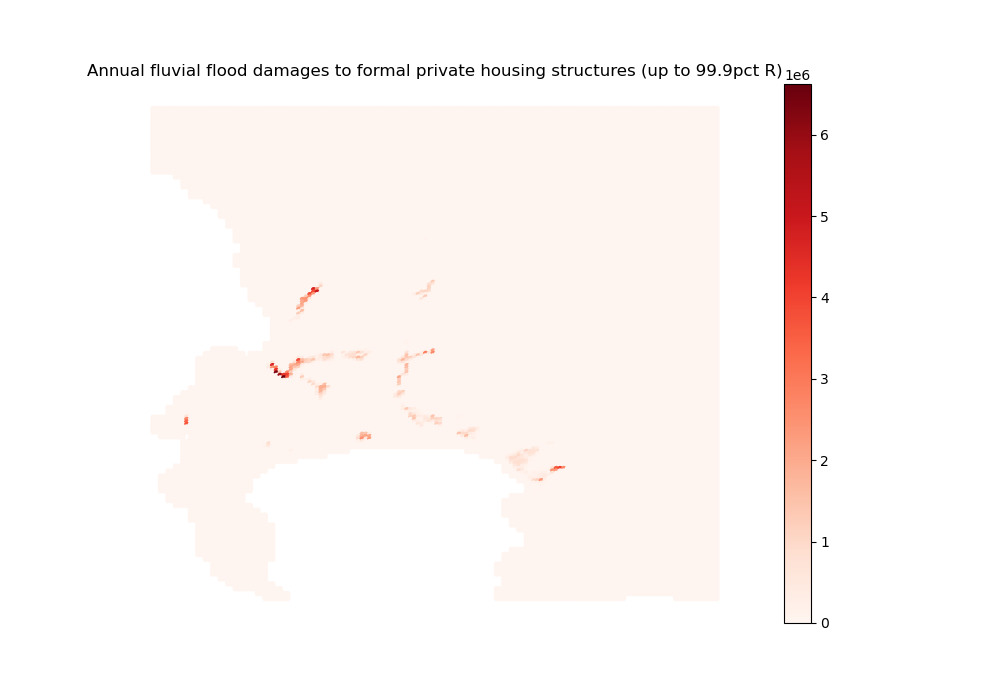

In [63]:
# For structures damaged by fluvial floods
fluvialu_damages_2d_sim_stacked = np.stack(
    [df for df in fluvialu_damages_2d_sim.values()])
fluvialu_formal_structure_2d_sim = np.zeros(24014)

import outputs.flood_outputs as outfld
for j in np.arange(24014):
    fluvialu_formal_structure_2d_sim[j] = outfld.annualize_damages(
        fluvialu_damages_2d_sim_stacked[:, j, 0],
        'fluvialu', 'formal', options)

import outputs.export_outputs as outexp
outexp.export_map(fluvialu_formal_structure_2d_sim, grid, geo_grid,
                  path_output_plots,
                  "fluvialu_formal_structure_2d_sim",
                  "Annual fluvial flood damages to formal private housing structures (up to 99.9pct R)", path_output_tables,
                  ubnd=np.quantile(fluvialu_formal_structure_2d_sim[fluvialu_formal_structure_2d_sim > 0], 0.999))

Image(path_output_plots + "fluvialu_formal_structure_2d_sim.png")

pluvial_formal_structure_2d_sim done


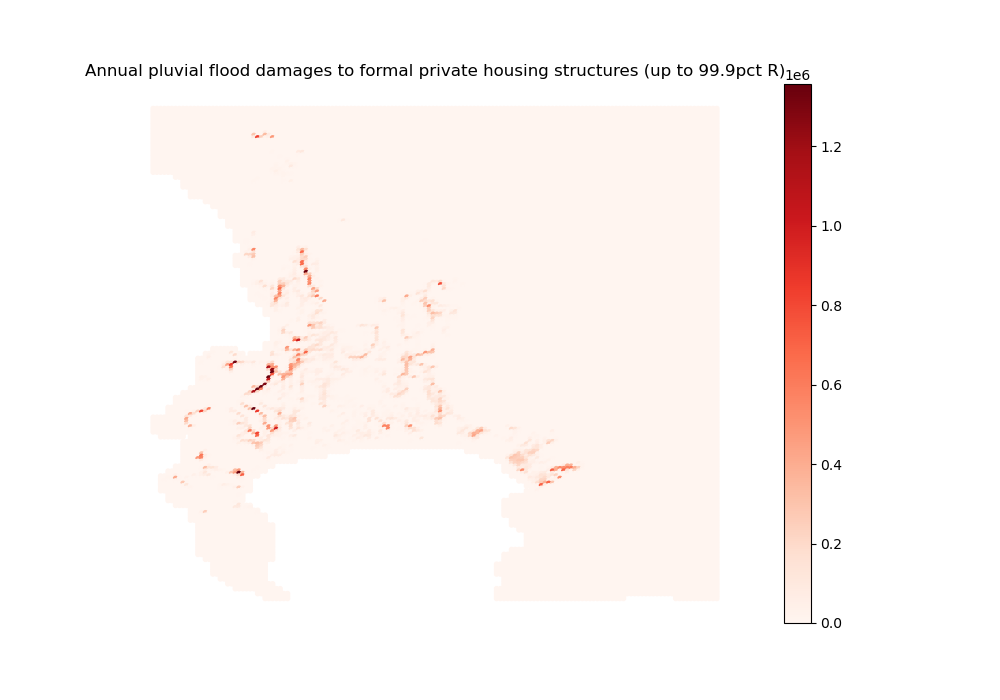

In [64]:
# For structures damaged by pluvial floods
pluvial_damages_2d_sim_stacked = np.stack(
    [df for df in pluvial_damages_2d_sim.values()])
pluvial_formal_structure_2d_sim = np.zeros(24014)

import outputs.flood_outputs as outfld
for j in np.arange(24014):
    pluvial_formal_structure_2d_sim[j] = outfld.annualize_damages(
        pluvial_damages_2d_sim_stacked[:, j, 0],
        'pluvial', 'formal', options)

import outputs.export_outputs as outexp
outexp.export_map(pluvial_formal_structure_2d_sim, grid, geo_grid,
                  path_output_plots,
                  "pluvial_formal_structure_2d_sim",
                  "Annual pluvial flood damages to formal private housing structures (up to 99.9pct R)", path_output_tables,
                  ubnd=np.quantile(pluvial_formal_structure_2d_sim[pluvial_formal_structure_2d_sim > 0], 0.999))

Image(path_output_plots + "pluvial_formal_structure_2d_sim.png")

coastal_formal_structure_2d_sim done


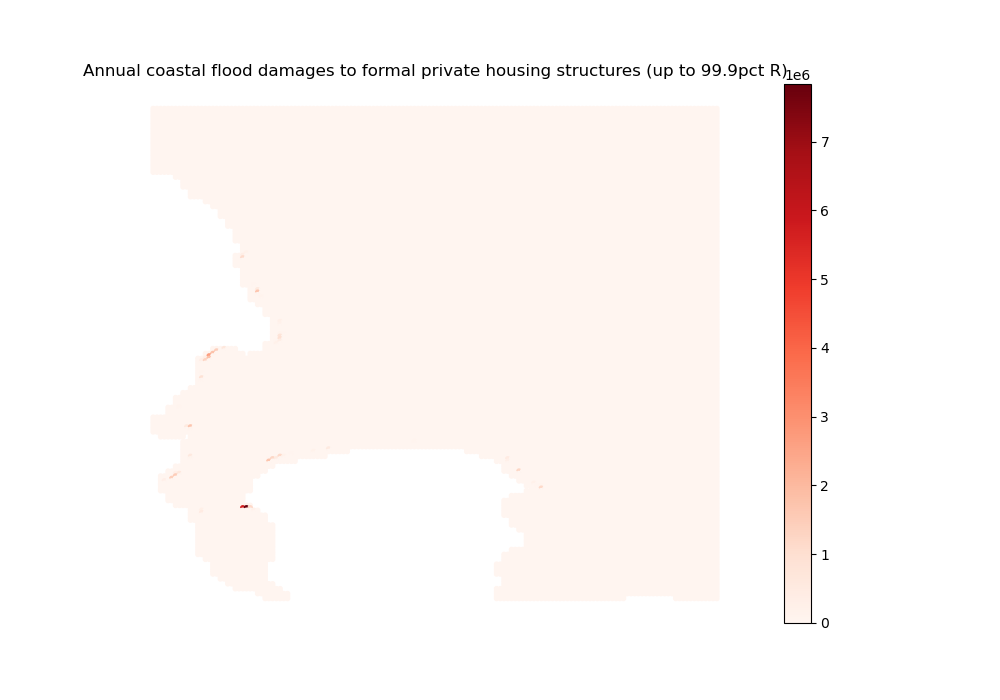

In [65]:
# For structures damaged by coastal floods
coastal_damages_2d_sim_stacked = np.stack(
    [df for df in coastal_damages_2d_sim.values()])
coastal_formal_structure_2d_sim = np.zeros(24014)
for j in np.arange(24014):
    coastal_formal_structure_2d_sim[j] = outfld.annualize_damages(
        coastal_damages_2d_sim_stacked[:, j, 0],
        'coastal', 'formal', options)

import outputs.export_outputs as outexp
outexp.export_map(coastal_formal_structure_2d_sim, grid, geo_grid,
                  path_output_plots,
                  "coastal_formal_structure_2d_sim",
                  "Annual coastal flood damages to formal private housing structures (up to 99.9pct R)", path_output_tables,
                  ubnd=np.quantile(coastal_formal_structure_2d_sim[coastal_formal_structure_2d_sim > 0], 0.999))

Image(path_output_plots + "coastal_formal_structure_2d_sim.png")

As could have been expected from the flood maps, fluvial damages are more acute but also more localized than pluvial damages. When superimposing the maps with what we obtained above on population spatial distribution, households appear to avoid the worst-affected areas, but are willing to trade off some flood exposure for good locations nearby the CBD (especially regarding fluvial flood risks). When superimposing them with the raw flood maps, we remark that the biggest pluvial damages occur in such places where flood exposure is not the highest: it is rather the increase in exposed capital value (driven by a relaxed trade-off) that causes the impact.

The same mechanism seems at play regarding coastal damages, but the estimated damages are well above standard estimates from the literature. This reflects the methodology we adopt: destroyed capital values are determined endogenously through the housing market, and not calibrated to reflect some maximum share of exposed capital at the city-level. As values are typically high near the CBD and in high-amenity areas, so are damages when floods hit such areas.